In [496]:
# import the necessary packages for our analysis
import pandas as pd
import numpy as np

from dateutil.parser import parse
from datetime import datetime
import dateutil.parser

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


import glob
import os
import zipfile

import timeit
import requests

from bs4 import BeautifulSoup
import re
import urllib
from bs4 import BeautifulSoup, element

import nltk

import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.model_selection import KFold


## Introduction

In this project, we will be looking at the **potential relationship between unit sales of a video game and the corresponding streaming metrics on Twitch**. Specifically, we will be looking at: 

- Watch Time
- Stream Time
- Peak Viewers (the highest number of concurrent watchers on a particular title)
- Peak Channels (the highest number of concurrent streamers on a particular title)
- Streamers
- Average Viewers
- Average Channels

We will be utilizing stats collected on SullyGnome (A third-party Twitch stats and analysis site) for the streaming metrics and scraping data on unit sales from VGChartz. The data collected on both sources is global. We are not limiting this study to a single country. The data available on SullyGnome is only accessible from 2016 to the present so we are limiting our study to 2016 onward.

A quick additional note about VGChartz...All sales information are only estimates and are arrived at via a number of proprietary and evder-developing methods, including:

- Passively polling end users to find out what games they are currently purchasing and playing
- Polling retail partners to find out what games and hardware they are selling
- Using statistical trend fitting and historical data for similar games
- Studying resell prices to determine consumer demand and inventory levels
- Consulting with publishers and manufacturers to find out how many units they are introducing into the channel

With the ground work laid, let's dive right in!



## Part I. A Global Look At The Industry

For this study, we will begin by looking at unit sales for all games (yes, ALL games) and their corresponding stats on Twitch from 2016 to the present. We'll need to scrape this info from VGChartz using the beautiful..uh Beautiful Soup

In [ ]:
def find_console_tags(soup):
    # Console tags are stored as images, so we find the image tag and record its 'alt' value as text
    consoles = list()
    for img in soup.find_all('img'):
        if 'images/consoles'in img['src']:
            # Cut file path elements from string
            console_tag = (img['src'][17:-6])
            consoles.append(img['alt'])
    return consoles


# Find the names of games from the links
def find_names_column(table_path):
    names_list = list()
    for row in table_path.xpath('.//tr'):
        for td in row.xpath('.//td'):
            if not td.find('a') is None:
                names_list.append(td.find('a').text.strip()) 
    return names_list

# Write a function that takes in a VGChartz URL and gives us all the data in their video game database
def scrape_vgchartz_videogame_db_page(url):
    
    response = requests.get(url)

    ### Check the Status
    assert(response.status_code == 200)," Website not OK " # status code = 200 => OK
    
    #Store the contents of the website under doc
    page=response.text
    soup = BeautifulSoup(page, "lxml")
    doc = lh.fromstring(response.content)
    
    # Selects the table with all the data in it on HTML using xpath
    target_table_path = doc.xpath('//*[@id="generalBody"]/table')[0]

    # Find column values that won't be scraped correctly with .text option
    names_list = find_names_column(target_table_path)
    consoles = find_console_tags(soup)
    
    # Parse non-image and non-URL info from the data table to a pandas DataFrame
    row_dict={}
    df=pd.DataFrame()
    row_list= list()
    for counter,row in enumerate(target_table_path.xpath(".//tr")):
        if counter > 2: # To skip header rows
            row_list=[td.text for td in row.xpath(".//td")]
            row_dict[counter] = row_list

    df=pd.DataFrame.from_dict(row_dict).transpose()
    df.columns = ['position','game','blank','console','publisher','developer','vgchart_score',\
                 'critic_score','user_score','total_shipped','total_sales',\
                  'na_sales','pal_sales','japan_sales','other_sales',\
                  'release_date','last_update']
    
    # Correct the console and game columns using scraped values
    
    df=df.reset_index().drop(columns = ['index','blank'])
    df['console'] = consoles
    df['game'] = names_list
    return df

    # We can 'hack' the URL to display any number of results per page. I'll leave it as an argument.
def scrape_all_vg_chartz_videogame_db(results_per_page):
    df = pd.DataFrame()
    current_page = 1
    games_left = True
    while games_left:
        url = 'http://www.vgchartz.com/games/games.php?page=' + str(current_page) +\
        '&results=' + str(results_per_page) + '&name=&console=&keyword=&publisher=&genre=&order=Sales&ownership\
        =Both&boxart=Both&banner=Both&showdeleted=&region=All&goty_year=&developer=&direction\
        =DESC&showtotalsales=1&shownasales=1&showpalsales=1&showjapansales=1&showothersales=1&\
        showpublisher=1&showdeveloper=1&showreleasedate=1&showlastupdate=1&showvgchartzscore=1&\
        showcriticscore=1&showuserscore=1&showshipped=1&alphasort=&showmultiplat=No'
        new_df = scrape_vgchartz_videogame_db_page(url)
        df = df.append(new_df)

        #REMOVE LATER, TEST CONDIITON
      #  if current_page > 3:
       #     games_left = False
        print('Scraped page: ',current_page)
        if new_df.shape[0] < results_per_page:
            games_left = False
        current_page +=1
    print('Scraping done!')
    print('Total rows parsed = ', df.shape[0])
    return df.reset_index().drop(columns = 'index')

# Run the code to scrape! I did 10,000 rows per page to speed things up.
df=scrape_all_vg_chartz_videogame_db(10000)

# Compress and store for later!
df.to_csv(vgsales.csv, sep=",", encoding='utf-8', index=False)
print("Wrote scraper data to", csvfilename)

In [14]:
# import videogame sales info from the csv we generated above
sales_df = pd.read_csv("vgsales.csv")

In [15]:
# preview the data
sales_df.head()

,position,game,console,publisher,developer,vgchart_score,critic_score,user_score,total_shipped,total_sales,na_sales,pal_sales,japan_sales,other_sales,release_date,last_update
0,1,Wii Sports,Wii,Nintendo,Nintendo EAD,N/A,7.7,N/A,82.87m,NaN,NaN,NaN,NaN,NaN,19th Nov 06,NaN
1,2,Super Mario Bros.,NES,Nintendo,Nintendo EAD,N/A,10.0,8.2,40.24m,NaN,NaN,NaN,NaN,NaN,18th Oct 85,NaN
2,3,Mario Kart Wii,Wii,Nintendo,Nintendo EAD,8.7,8.2,9.1,37.20m,NaN,NaN,NaN,NaN,NaN,27th Apr 08,11th Apr 18
3,4,PLAYERUNKNOWN'S BATTLEGROUNDS,PC,PUBG Corporation,PUBG Corporation,N/A,N/A,N/A,36.60m,NaN,NaN,NaN,NaN,NaN,21st Dec 17,29th Apr 19
4,5,Wii Sports Resort,Wii,Nintendo,Nintendo EAD,8.8,8.0,8.8,33.10m,NaN,NaN,NaN,NaN,NaN,26th Jul 09,NaN


In [16]:
# preview data types
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56332 entries, 0 to 56331
Data columns (total 16 columns):
position         56332 non-null int64
game             56332 non-null object
console          56332 non-null object
publisher        56332 non-null object
developer        56332 non-null object
vgchart_score    56332 non-null object
critic_score     56332 non-null object
user_score       56332 non-null object
total_shipped    1976 non-null object
total_sales      19395 non-null object
na_sales         12951 non-null object
pal_sales        13180 non-null object
japan_sales      7034 non-null object
other_sales      15507 non-null object
release_date     56332 non-null object
last_update      10107 non-null object
dtypes: int64(1), object(15)
memory usage: 6.9+ MB


Hmm...well the scrape worked but we can see in the above warning and header preview that we have some serious cleaning to do. Let's do some of that before we move on.

In [17]:
# lowercase all columns
sales_df.columns = [x.lower() for x in sales_df.columns]

In [18]:
# lowercase games for standardization
sales_df['game'] = sales_df['game'].str.lower()

We see a bunch of noise in the game title, so let's write a quick function to clean up the formatting.

In [19]:
# function to clean game title data 
def game_title(game):
    return game.split('(')[0].strip()

We also see that sales is a type string and is formatted like '6.5m'. Let's write another function to clean that up.

In [20]:
# function to convert and format string to float
def convert_to_int(s):
    return float(s) * 1000000

In [21]:
# take off the 'm' from unit sales so we can convert to floats
sales_df['total_sales'] = sales_df['total_sales'].str.replace('m','')

In [22]:
# apply that function to the column total sales to complete our transformation
sales_df['total_sales'] = sales_df['total_sales'].apply(convert_to_int)

In [23]:
# drop a bunch of columns that we won't be needing for our analysis
sales_df = sales_df.drop(['position', 'vgchart_score', 'publisher', 'developer', 'total_shipped', 'critic_score', 'user_score', 'na_sales', 'pal_sales', 'japan_sales', 'other_sales', 'last_update'], axis=1)

In [29]:
# replace all blank rows with NaN
sales_df = (sales_df.replace(r'^\s*$', np.nan, regex=True))

In [30]:
# drop all rows in which total sales is a NaN
sales_df = sales_df[np.isfinite(sales_df['total_sales'])]

In [34]:
# take out values of 0 in the total_sales column
sales_df = sales_df[sales_df.total_sales != 0.0]

In [36]:
# let's again preview 
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18022 entries, 19 to 19997
Data columns (total 4 columns):
game            18022 non-null object
console         18022 non-null object
total_sales     18022 non-null float64
release_date    18022 non-null object
dtypes: float64(1), object(3)
memory usage: 704.0+ KB


In [37]:
# twitch displays all streaming metrics per title aggregating all platforms together so let's do that here
sales_df = sales_df.groupby(['game'])['total_sales'].sum().reset_index()

### Twitch Data

Great! Now that we have the sales information cleaned, let's bring in the streaming data from Sully Gnome

In [39]:
# let's bring in the top 1000 games on twitch globally from 2016 - 2018
twitch_df = pd.read_csv('twitch2018.csv')

In [40]:
# lowercase columns 
twitch_df.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [41]:
# lowercase games for standardization
twitch_df['game'] = twitch_df['game'].str.lower()

Awesome. Now let's merge the two dataframes together on the common column: game.

In [42]:
# merge dfs
combined_df = pd.merge(sales_df, twitch_df, on='game')

In [43]:
# preview our work
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899 entries, 0 to 898
Data columns (total 15 columns):
game                    899 non-null object
total_sales             899 non-null float64
Unnamed: 0              899 non-null object
Unnamed: 1              899 non-null int64
watch_time              899 non-null int64
stream_time             899 non-null int64
peak_viewers            899 non-null int64
peak_channels           899 non-null int64
streamers               899 non-null int64
average_viewers         899 non-null int64
average_channels        899 non-null int64
average_viewer_ratio    899 non-null float64
followers_gained        899 non-null int64
views_gained            899 non-null int64
Unnamed: 13             899 non-null object
dtypes: float64(2), int64(10), object(3)
memory usage: 112.4+ KB


In [44]:
# take out columns not needed for our analysis
combined_df = combined_df.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


### Looking at our correlations

In [45]:
combined_df.corr()

,total_sales,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
total_sales,1.000000,0.083752,0.058054,0.081647,0.084987,0.115671,0.083753,0.058004,-0.066422
watch_time,0.083752,1.000000,0.989380,0.781615,0.922178,0.983654,1.000000,0.989381,-0.012151
stream_time,0.058054,0.989380,1.000000,0.762684,0.935933,0.991187,0.989380,1.000000,-0.012390
peak_viewers,0.081647,0.781615,0.762684,1.000000,0.796632,0.783000,0.781613,0.762677,0.055227
peak_channels,0.084987,0.922178,0.935933,0.796632,1.000000,0.938567,0.922177,0.935924,-0.018842
streamers,0.115671,0.983654,0.991187,0.783000,0.938567,1.000000,0.983654,0.991174,-0.018507
average_viewers,0.083753,1.000000,0.989380,0.781613,0.922177,0.983654,1.000000,0.989381,-0.012149
average_channels,0.058004,0.989381,1.000000,0.762677,0.935924,0.991174,0.989381,1.000000,-0.012193
average_viewer_ratio,-0.066422,-0.012151,-0.012390,0.055227,-0.018842,-0.018507,-0.012149,-0.012193,1.000000


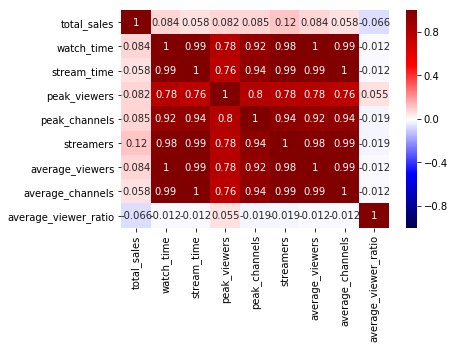

In [46]:
sns.heatmap(combined_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


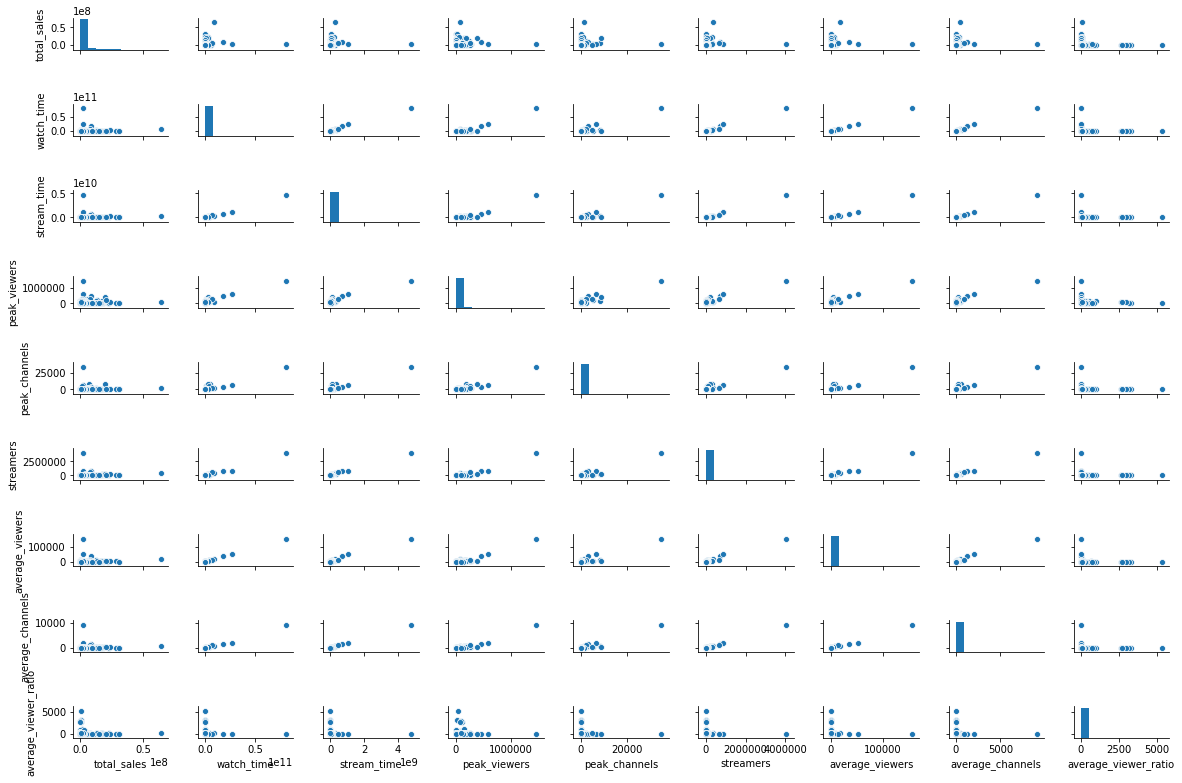

In [47]:
sns.pairplot(combined_df, height=1.2, aspect=1.5);

Well...as expected we see a very high correlation between our streaming metrics. In fact, we see some strong signs of multi-collinearity. We'll keep this in mind as we build and refine our models throughout the study. However, we also see a pretty weak signal between all these streaming metrics and the target: total sales. 

Let's bring in stats models to look at our summary stastics in more detail. 

**This is a good place to say that we are going to be predominantely looking at adjusted R2 as our success metric. We are more interested in understanding the relationship between our features and target rather than trying to predict the target variable in the future (in which case we might look at RMSE).**

In [48]:
# Define the model
lm1 = smf.ols('total_sales ~ watch_time + stream_time + average_channels + average_viewers + peak_channels + peak_viewers + streamers', data=combined_df)

# Fit the model
fit = lm1.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_sales   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     36.91
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           1.68e-45
Time:                        16:32:18   Log-Likelihood:                -14889.
No. Observations:                 899   AIC:                         2.979e+04
Df Residuals:                     891   BIC:                         2.983e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.874e+06   3.17e+05      5.906      0.000    1.25e+06     2.5e+06
watch_time          -0.1756      0.814     -0.216      0.829      -1.773       1.421
stream_time          0.1429      0.850      0.168      0.867      -1.526       1.811
average_channels -1.335e+05   4.46e+05     -0.299      0.765   -1.01e+06    7.43e+05
average_viewers   9.312e+04   4.28e+05      0.218      0.828   -7.46e+05    9.32e+05
peak_channels      445.9591    308.925      1.444      0.149    -160.347    1052.265
peak_viewers       -13.5824      3.209     -4.233      0.000     -19.880      -7.285
streamers          100.0863      7.088     14.120      0.000      86.174     113.998
==============================================================================
Omnibus:                      787.364   Durbin-Watson:                   1.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28948.682
Skew:                           3.845   Prob(JB):                         0.00
Kurtosis:                      29.715   Cond. No.                     1.24e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Unsurprisingly, we see some echoes of what we anticipated above. We see strong signs of collinearity in the high condition number and a pretty low adjusted R2. 

However, looking at the coefficients we see something very interesting...Whereas the majority of the features give us low to no signal, the peak_channel metric has a value of 445.95. This means that for every additional peak channel, we are seeing an additional 445 units sold. This is something we should be paying attention to as our study moves forward.

For now though, even though we don't see much of a signal let's at the very least take our some of the high P scores and see if that helps our model at all. According to this summary, we see pretty high scores for average viewers, average channels, as well as stream and watch time. 

We probably don't want to take all these out intuitively as we want to retain as close to 10 times the number of observations to features. In addition, we intuitively want to capture stream and watch time to understand the overall volume of streams and viewership. Thus, let's just take out the averages for now.

In [51]:
# Define the model
lm12 = smf.ols('total_sales ~ peak_channels +  + stream_time + watch_time + peak_viewers + streamers', data=combined_df)

# Fit the model
fit2 = lm12.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            total_sales   R-squared:                       0.225
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     51.76
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           3.44e-47
Time:                        16:40:21   Log-Likelihood:                -14889.
No. Observations:                 899   AIC:                         2.979e+04
Df Residuals:                     893   BIC:                         2.982e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1.883e+06   1.48e+05     12.721      0.000    1.59e+06    2.17e+06
peak_channels   443.7850    308.335      1.439      0.150    -161.360    1048.930
stream_time      -0.1114      0.008    -14.312      0.000      -0.127      -0.096
watch_time        0.0016      0.000      4.965      0.000       0.001       0.002
peak_viewers    -13.6254      3.203     -4.254      0.000     -19.911      -7.339
streamers       100.3849      7.032     14.276      0.000      86.584     114.185
==============================================================================
Omnibus:                      786.180   Durbin-Watson:                   1.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28705.973
Skew:                           3.839   Prob(JB):                         0.00
Kurtosis:                      29.597   Cond. No.                     3.50e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.5e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

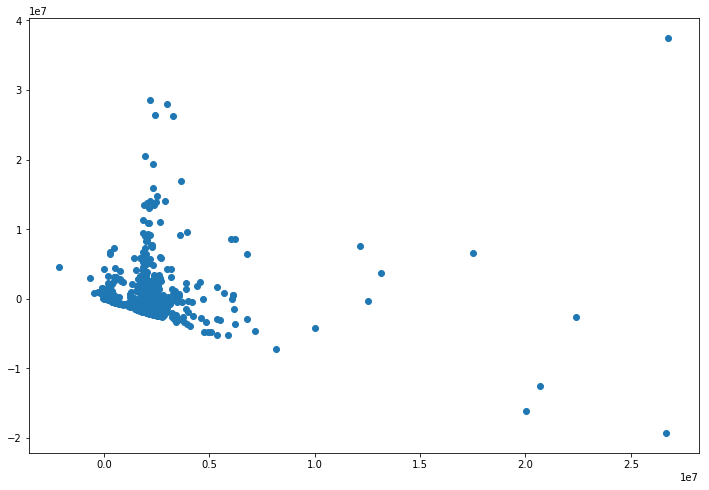

In [52]:

# let's also plot the residuals vs the fitted values from our first fitted model
plt.figure(figsize=(12,8))
plt.scatter(fit.predict(), fit.resid);

Well, we squashed those high P scores but our model is pretty much unchanged. We also see a high concentration of residuals on the left side of diagram. We should be seeing a random distribution of errors across the x axis so we can safely say there is not a linear relationship between our features and target at this scale.

Let's move on from this scale and zoom in to see if we can get a better correlation in looking at a more focused dataset.

## Part II. Top Games From 2016 - 2018

We are now going to be focusing on the top 100 selling games in the years 2016 - 2018 and see if we get a better mapping to streaming metrics. 

We will again be scraping data from VGChartz. However, this time we can just use Pandas to read in a table rather than the complex script we ran beforehand.

### 2018

In [53]:
# bring in vg chart data from url
url = 'http://www.vgchartz.com/yearly/2018/Global/'

response = requests.get(url)

In [54]:
# make sure the site is responsive 
response.status_code

200

In [55]:
# define the tables variable
tables = pd.read_html(url)

In [56]:
# print out table from site using pandas
tables[1]

,Pos,Game,Game.1,Game.2,Weeks,Yearly,Total
0,1,Red Dead Redemption 2 (PS4)Take-Two Interactiv...,Red Dead Redemption 2 (PS4)Take-Two Interactiv...,Red Dead Redemption 2 (PS4)Take-Two Interactiv...,10,13940203,13940203
1,2,"Call of Duty: Black Ops IIII (PS4)Activision, ...","Call of Duty: Black Ops IIII (PS4)Activision, ...","Call of Duty: Black Ops IIII (PS4)Activision, ...",12,9317241,9317241
2,3,"FIFA 19 (PS4)Electronic Arts, Sports","FIFA 19 (PS4)Electronic Arts, Sports","FIFA 19 (PS4)Electronic Arts, Sports",14,9147505,9147505
3,4,"Super Smash Bros. (2018) (NS)Nintendo, Fighting","Super Smash Bros. (2018) (NS)Nintendo, Fighting","Super Smash Bros. (2018) (NS)Nintendo, Fighting",4,8951009,8951009
4,5,Spider-Man (PS4) (PS4)Sony Interactive Enterta...,Spider-Man (PS4) (PS4)Sony Interactive Enterta...,Spider-Man (PS4) (PS4)Sony Interactive Enterta...,17,8757859,8757859
5,6,"Mario Kart 8 Deluxe (NS)Nintendo, Racing","Mario Kart 8 Deluxe (NS)Nintendo, Racing","Mario Kart 8 Deluxe (NS)Nintendo, Racing",88,6688249,13046117
6,7,God of War (PS4) (PS4)Sony Interactive Enterta...,God of War (PS4) (PS4)Sony Interactive Enterta...,God of War (PS4) (PS4)Sony Interactive Enterta...,37,6153527,6153527
7,8,Red Dead Redemption 2 (XOne)Take-Two Interacti...,Red Dead Redemption 2 (XOne)Take-Two Interacti...,Red Dead Redemption 2 (XOne)Take-Two Interacti...,10,5771147,5771147
8,9,"Super Mario Party (NS)Nintendo, Party","Super Mario Party (NS)Nintendo, Party","Super Mario Party (NS)Nintendo, Party",13,4972711,4972711
9,10,"Call of Duty: Black Ops IIII (XOne)Activision,...","Call of Duty: Black Ops IIII (XOne)Activision,...","Call of Duty: Black Ops IIII (XOne)Activision,...",12,4850704,4850704


In [63]:
# convert list object to a dataframe 
sales_df_2018 = pd.DataFrame(tables[1])

In [64]:
# take out columns that are not needed for analysis
columns = ['Pos', 'Game.1', 'Game.2']
sales_df_2018 = sales_df_2018.drop(columns, axis=1)

In [65]:
# Apply our game_title function to format game titles in the table
sales_df_2018['Game'] = sales_df_2018['Game'].apply(game_title)

In [66]:
# lower case the game rows so that they are compatible with Twitch dataframe
sales_df_2018['Game'] = sales_df_2018['Game'].str.lower()

In [67]:
# format columns in lowercase
sales_df_2018.columns = [x.lower() for x in sales_df_2018.columns]


In [68]:
# group by game title to sum unit sales per game (currently broken down by platform)
sales_df_2018 = sales_df_2018.groupby(['game'])['yearly'].sum().reset_index()

In [74]:
# preview our work
sales_df.head()

,game,yearly
0,1-2-switch,888949
1,assassin's creed odyssey,4564139
2,assassin's creed origins,1492024
3,astro bot rescue mission,713531
4,battlefield v,3771595


### 2017

In [75]:
url2 = 'http://www.vgchartz.com/yearly/2017/Global/'

response2 = requests.get(url2)

In [76]:
tables2 = pd.read_html(url2)

In [77]:
tables2[1]

,Pos,Game,Game.1,Game.2,Weeks,Yearly,Total
0,1,"Call of Duty: WWII (PS4)Activision, Shooter","Call of Duty: WWII (PS4)Activision, Shooter","Call of Duty: WWII (PS4)Activision, Shooter",9,11665414,11665414
1,2,"FIFA 18 (PS4)Electronic Arts, Sports","FIFA 18 (PS4)Electronic Arts, Sports","FIFA 18 (PS4)Electronic Arts, Sports",14,10107910,10107910
2,3,"Super Mario Odyssey (NS)Nintendo, Platform","Super Mario Odyssey (NS)Nintendo, Platform","Super Mario Odyssey (NS)Nintendo, Platform",10,7715648,7715648
3,4,"Mario Kart 8 Deluxe (NS)Nintendo, Racing","Mario Kart 8 Deluxe (NS)Nintendo, Racing","Mario Kart 8 Deluxe (NS)Nintendo, Racing",36,6357868,6357868
4,5,The Legend of Zelda: Breath of the Wild (NS)Ni...,The Legend of Zelda: Breath of the Wild (NS)Ni...,The Legend of Zelda: Breath of the Wild (NS)Ni...,44,6073816,6073816
5,6,"Call of Duty: WWII (XOne)Activision, Shooter","Call of Duty: WWII (XOne)Activision, Shooter","Call of Duty: WWII (XOne)Activision, Shooter",9,5440378,5440378
6,7,Pokemon: Ultra Sun and Ultra Moon (3DS)Nintend...,Pokemon: Ultra Sun and Ultra Moon (3DS)Nintend...,Pokemon: Ultra Sun and Ultra Moon (3DS)Nintend...,7,5308897,5308897
7,8,Horizon: Zero Dawn (PS4)Sony Interactive Enter...,Horizon: Zero Dawn (PS4)Sony Interactive Enter...,Horizon: Zero Dawn (PS4)Sony Interactive Enter...,44,4507665,4507665
8,9,"Splatoon 2 (NS)Nintendo, Shooter","Splatoon 2 (NS)Nintendo, Shooter","Splatoon 2 (NS)Nintendo, Shooter",24,4104949,4104949
9,10,Crash Bandicoot N. Sane Trilogy (PS4)Activisio...,Crash Bandicoot N. Sane Trilogy (PS4)Activisio...,Crash Bandicoot N. Sane Trilogy (PS4)Activisio...,27,3615050,3615050


In [78]:
# convert list object to a dataframe 
sales_df2 = pd.DataFrame(tables2[1])

In [79]:
# take out columns that are not needed for analysis
columns = ['Pos', 'Game.1', 'Game.2']
sales_df2 = sales_df2.drop(columns, axis=1)

In [80]:
# Apply a function to format game title 
sales_df2['Game'] = sales_df2['Game'].apply(game_title)

In [81]:
# lower case the game rows so that they are compatible with Twitch dataframe
sales_df2['Game'] = sales_df2['Game'].str.lower()

In [82]:
# format columns in lowercase
sales_df2.columns = [x.lower() for x in sales_df2.columns]

In [83]:
# group by game title to sum unit sales per game (currently broken down by platform)
sales_df2 = sales_df2.groupby(['game'])['yearly'].sum().reset_index()

### 2016

In [84]:
# bring in vg chart data from url
url3 = 'http://www.vgchartz.com/yearly/2016/Global/'

response3 = requests.get(url3)


In [85]:
tables3 = pd.read_html(url3)

In [86]:
tables3[1]

,Pos,Game,Game.1,Game.2,Weeks,Yearly,Total
0,1,"Pokemon Sun/Moon (3DS)Nintendo, Role-Playing","Pokemon Sun/Moon (3DS)Nintendo, Role-Playing","Pokemon Sun/Moon (3DS)Nintendo, Role-Playing",7,12034530,12034530
1,2,"FIFA 17 (PS4)Electronic Arts, Sports","FIFA 17 (PS4)Electronic Arts, Sports","FIFA 17 (PS4)Electronic Arts, Sports",14,9581584,9581584
2,3,Uncharted (PS4) (PS4)Sony Computer Entertainme...,Uncharted (PS4) (PS4)Sony Computer Entertainme...,Uncharted (PS4) (PS4)Sony Computer Entertainme...,34,8298741,8298741
3,4,Call of Duty: Infinite Warfare (PS4)Activision...,Call of Duty: Infinite Warfare (PS4)Activision...,Call of Duty: Infinite Warfare (PS4)Activision...,9,6195297,6195297
4,5,"Battlefield 1 (PS4)Electronic Arts, Shooter","Battlefield 1 (PS4)Electronic Arts, Shooter","Battlefield 1 (PS4)Electronic Arts, Shooter",11,5961774,5961774
5,6,"Battlefield 1 (XOne)Electronic Arts, Shooter","Battlefield 1 (XOne)Electronic Arts, Shooter","Battlefield 1 (XOne)Electronic Arts, Shooter",11,4219657,4219657
6,7,"Grand Theft Auto V (PS4)Take-Two Interactive, ...","Grand Theft Auto V (PS4)Take-Two Interactive, ...","Grand Theft Auto V (PS4)Take-Two Interactive, ...",111,4104297,13637345
7,8,"Call of Duty: Black Ops 3 (PS4)Activision, Sho...","Call of Duty: Black Ops 3 (PS4)Activision, Sho...","Call of Duty: Black Ops 3 (PS4)Activision, Sho...",61,4035701,14494243
8,9,"Tom Clancy's The Division (PS4)Ubisoft, Misc","Tom Clancy's The Division (PS4)Ubisoft, Misc","Tom Clancy's The Division (PS4)Ubisoft, Misc",43,4029849,4029849
9,10,"Final Fantasy XV (PS4)Square Enix, Role-Playing","Final Fantasy XV (PS4)Square Enix, Role-Playing","Final Fantasy XV (PS4)Square Enix, Role-Playing",5,3917803,3917803


In [87]:
# convert list object to a dataframe 
sales_df3 = pd.DataFrame(tables3[1])

In [88]:
# take out columns that are not needed for analysis
columns = ['Pos', 'Game.1', 'Game.2']
sales_df3 = sales_df3.drop(columns, axis=1)

In [89]:
# Apply a function to format game title 
sales_df3['Game'] = sales_df3['Game'].apply(game_title)

In [90]:
# lower case the game rows so that they are compatible with Twitch dataframe
sales_df3['Game'] = sales_df3['Game'].str.lower()

In [91]:
# format columns in lowercase
sales_df3.columns = [x.lower() for x in sales_df3.columns]

In [92]:
# group by game title to sum unit sales per game (currently broken down by platform)
sales_df3 = sales_df3.groupby(['game'])['yearly'].sum().reset_index()

In [104]:
sales_df3.head()

,game,yearly
0,animal crossing: new leaf,852589
1,assassin's creed syndicate,743880
2,batman: arkham knight,770709
3,battlefield 1,10181431
4,call of duty: black ops 3,5454752


### Combining The Three Years

In [94]:
# combine the three dataframes
combined_charts = pd.concat([sales_df, sales_df2, sales_df3], axis=0)

In [95]:
combined_charts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 231 entries, 0 to 72
Data columns (total 2 columns):
game      231 non-null object
yearly    231 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.4+ KB


In [96]:
# group by game title to sum unit sales per game (currently broken down by platform)
combined_charts = combined_charts.groupby(['game'])['yearly'].sum().reset_index()

### Read in Twitch Data

In [97]:
# read in all twitch data for 2016-2018
twitch_df = pd.read_csv("twitch_final.csv")

In [98]:
# format columns 
twitch_df.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [99]:
twitch_df = twitch_df.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [100]:
# lower-case the game column for integration into sales_df
twitch_df['game'] = twitch_df['game'].str.lower()

In [101]:
# sum up the total stream time and watch time across the three years
twitch_sum = twitch_df.groupby(['game'])['stream_time', 'watch_time'].sum().reset_index()

In [102]:
# merge the chart and twitch data together
combined_df = pd.merge(combined_charts, twitch_sum, on='game')

In [103]:
# let's also make a second combined chart that has all the twitch metrics
combined_df2 = pd.merge(combined_charts, twitch_df, on='game')

### Plotting Our Correlations

First, let's look at the potential correlation between just stream/watch time and unit sales in the period.

In [105]:
combined_df.corr()

,yearly,stream_time,watch_time
yearly,1.000000,0.093823,0.115791
stream_time,0.093823,1.000000,0.966157
watch_time,0.115791,0.966157,1.000000


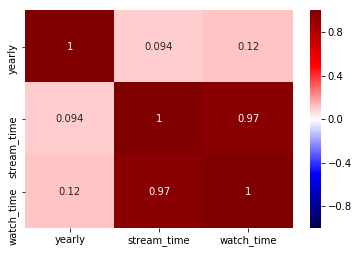

In [106]:
sns.heatmap(combined_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


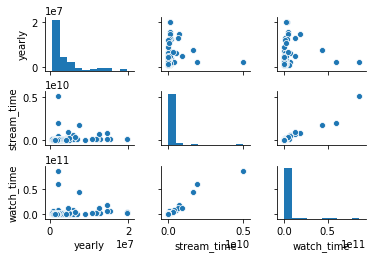

In [107]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(combined_df, height=1.2, aspect=1.5);


In [108]:
# Define the model
lm1 = smf.ols('yearly ~ watch_time + stream_time', data=combined_df)

# Fit the model
fit = lm1.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.081
Date:                Thu, 18 Jul 2019   Prob (F-statistic):              0.343
Time:                        17:18:07   Log-Likelihood:                -1974.7
No. Observations:                 119   AIC:                             3955.
Df Residuals:                     116   BIC:                             3964.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    3.347e+06   3.75e+05      8.932      0.000     2.6e+06    4.09e+06
watch_time      0.0001      0.000      1.060      0.292      -0.000       0.000
stream_time    -0.0021      0.003     -0.761      0.448      -0.007       0.003
==============================================================================
Omnibus:                       66.865   Durbin-Watson:                   1.649
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              209.794
Skew:                           2.183   Prob(JB):                     2.78e-46
Kurtosis:                       7.821   Cond. No.                     1.12e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ok...virtually no signal. Let's move on to the full twitch suite of metrics as before.

In [109]:
combined_df2.corr()

,yearly,average_channels,average_viewer_ratio,average_viewers,peak_channels,peak_viewers,stream_time,streamers,watch_time
yearly,1.000000,0.062436,-0.087189,0.084346,0.156609,0.149635,0.062460,0.164300,0.084404
average_channels,0.062436,1.000000,-0.050571,0.971768,0.866893,0.819266,1.000000,0.980901,0.971760
average_viewer_ratio,-0.087189,-0.050571,1.000000,-0.030120,-0.071328,0.043341,-0.050656,-0.080030,-0.030128
average_viewers,0.084346,0.971768,-0.030120,1.000000,0.832808,0.838108,0.971760,0.946491,1.000000
peak_channels,0.156609,0.866893,-0.071328,0.832808,1.000000,0.841400,0.866929,0.868091,0.832858
peak_viewers,0.149635,0.819266,0.043341,0.838108,0.841400,1.000000,0.819256,0.817761,0.838119
stream_time,0.062460,1.000000,-0.050656,0.971760,0.866929,0.819256,1.000000,0.980946,0.971753
streamers,0.164300,0.980901,-0.080030,0.946491,0.868091,0.817761,0.980946,1.000000,0.946520
watch_time,0.084404,0.971760,-0.030128,1.000000,0.832858,0.838119,0.971753,0.946520,1.000000


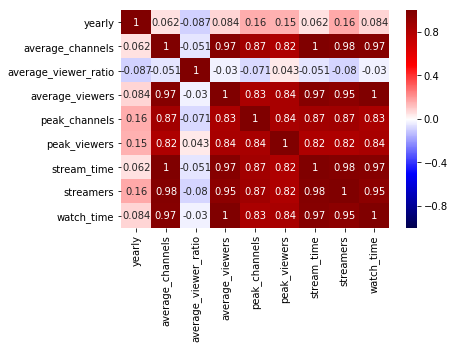

In [110]:
sns.heatmap(combined_df2.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


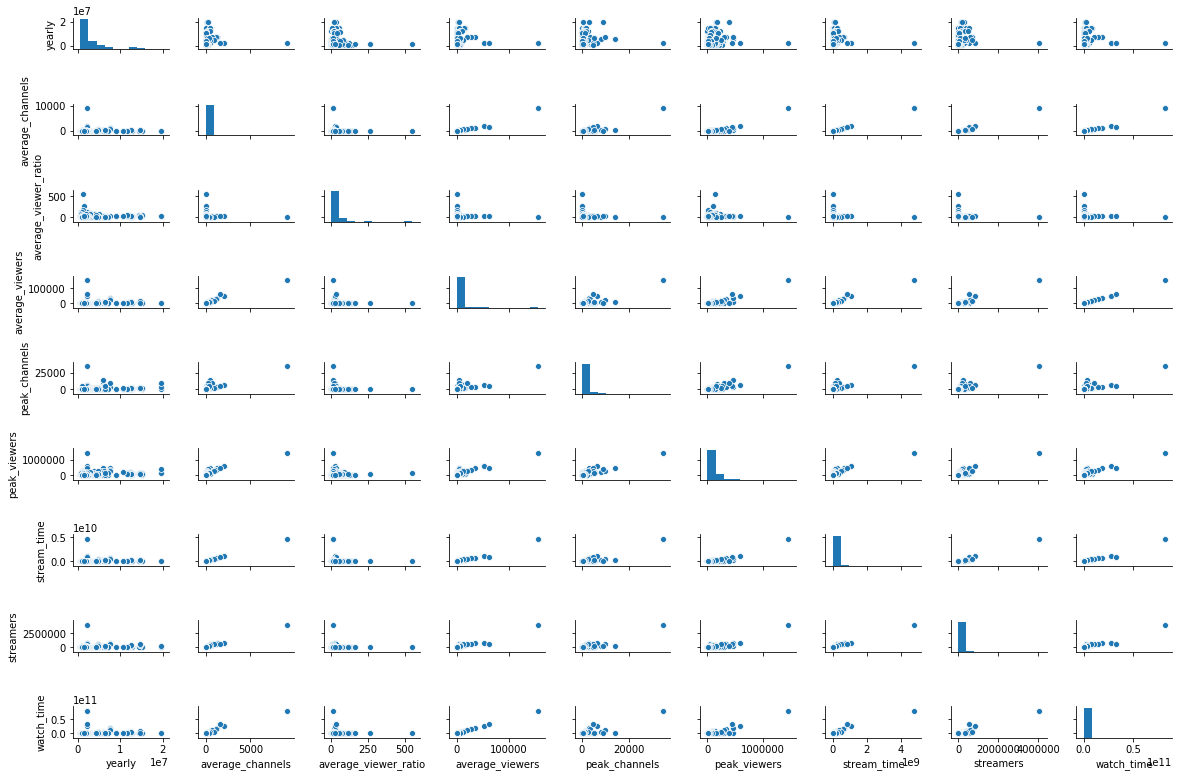

In [111]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(combined_df2, height=1.2, aspect=1.5);


In [112]:
# Define the model
lm1 = smf.ols('yearly ~ watch_time + stream_time + average_channels + average_viewers + peak_channels + peak_viewers + streamers', data=combined_df2)

# Fit the model
fit2 = lm1.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.386
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     20.96
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           8.47e-22
Time:                        17:19:28   Log-Likelihood:                -3946.2
No. Observations:                 241   AIC:                             7908.
Df Residuals:                     233   BIC:                             7936.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         3.126e+06   4.48e+05      6.985      0.000    2.24e+06    4.01e+06
watch_time          -0.2487      0.115     -2.168      0.031      -0.475      -0.023
stream_time         -3.6752      1.332     -2.760      0.006      -6.299      -1.051
average_channels  1.902e+06      7e+05      2.719      0.007    5.24e+05    3.28e+06
average_viewers   1.311e+05   6.03e+04      2.173      0.031    1.22e+04     2.5e+05
peak_channels      590.5371    186.353      3.169      0.002     223.385     957.690
peak_viewers        -4.1331      3.543     -1.167      0.245     -11.114       2.847
streamers           48.3570      4.416     10.951      0.000      39.657      57.057
==============================================================================
Omnibus:                       70.290   Durbin-Watson:                   0.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              166.140
Skew:                           1.358   Prob(JB):                     8.38e-37
Kurtosis:                       6.029   Cond. No.                     2.42e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.42e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

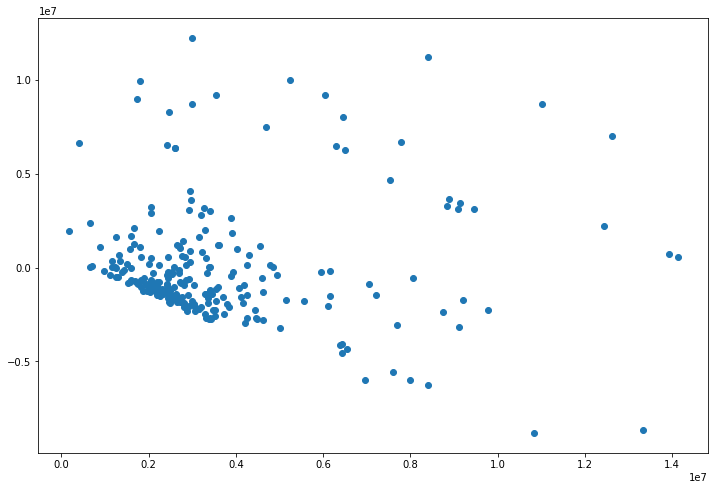

In [113]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(fit2.predict(), fit2.resid);

Well...this is better than what we saw before but we still see much of the same. Strong multicollinearity, weak signal between many of the streaming metrics and our target BUT again, an even stronger signal between peak channels and target. Now our coefficient is 590!

All this points to zooming in further. Instead of looking at 3 years of data, why don't we isolate a single year of data and see if our results improve before we begin refining our model via feature engineering, etc.

## Part III. A Look At 2018

We've already generated and cleaned our 2018 sales data we will begin by bringing in the Twitch 2018 data and concatenating the two together.

In [116]:
# read in twitch streaming data
twitch_2018 = pd.read_csv("twitch2018.csv")

In [117]:
# format columns 
twitch_2018.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [118]:
# lower-case the game column for integration into sales_df
twitch_2018['game'] = twitch_2018['game'].str.lower()

In [119]:
# merge two dataframes together
combined_2018 = pd.merge(sales_df_2018, twitch_2018, on='game')

In [120]:
# preview the dataframe
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 4 columns):
game           119 non-null object
yearly         119 non-null int64
stream_time    119 non-null int64
watch_time     119 non-null int64
dtypes: int64(3), object(1)
memory usage: 9.6+ KB


In [124]:

# take out columns not needed for our analysis
combined_2018 = combined_2018.drop(['Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13'], axis=1)


### Visualizing And Modeling 2018

In [125]:
combined_2018.corr()

,yearly,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
yearly,1.000000,-0.031071,-0.037949,0.117476,0.140384,-0.023223,-0.031073,-0.037938,-0.017714
watch_time,-0.031071,1.000000,0.989930,0.920980,0.918771,0.985044,1.000000,0.989934,-0.081546
stream_time,-0.037949,0.989930,1.000000,0.906248,0.937006,0.993577,0.989930,1.000000,-0.099522
peak_viewers,0.117476,0.920980,0.906248,1.000000,0.918816,0.914073,0.920981,0.906252,-0.050538
peak_channels,0.140384,0.918771,0.937006,0.918816,1.000000,0.933570,0.918770,0.937010,-0.121862
streamers,-0.023223,0.985044,0.993577,0.914073,0.933570,1.000000,0.985044,0.993572,-0.115833
average_viewers,-0.031073,1.000000,0.989930,0.920981,0.918770,0.985044,1.000000,0.989934,-0.081551
average_channels,-0.037938,0.989934,1.000000,0.906252,0.937010,0.993572,0.989934,1.000000,-0.099476
average_viewer_ratio,-0.017714,-0.081546,-0.099522,-0.050538,-0.121862,-0.115833,-0.081551,-0.099476,1.000000


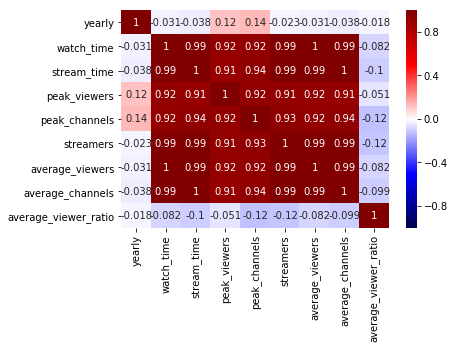

In [127]:
sns.heatmap(combined_2018.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


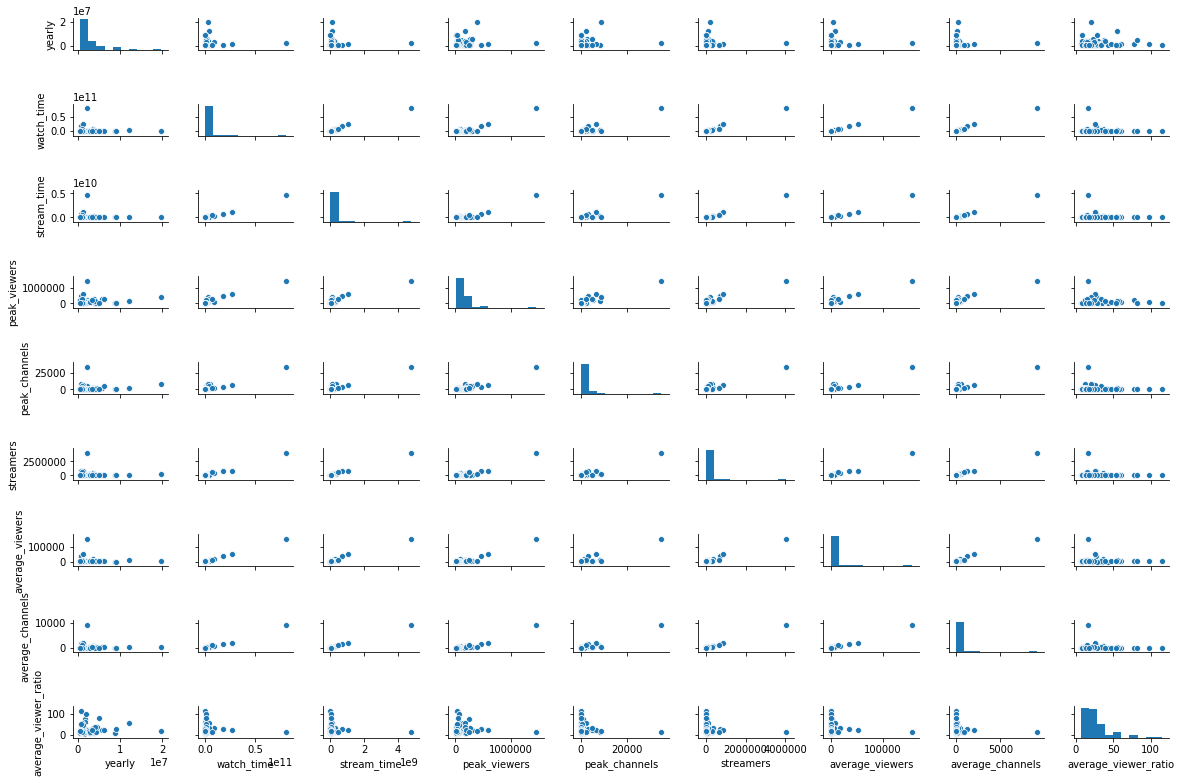

In [128]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(combined_2018, height=1.2, aspect=1.5);

In [130]:
# Define the model
lm1 = smf.ols('yearly ~ watch_time + stream_time + peak_viewers + peak_channels + streamers + average_viewers + average_channels + average_viewer_ratio', data=combined_2018)

# Fit the model
fit = lm1.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     2.534
Date:                Thu, 18 Jul 2019   Prob (F-statistic):             0.0216
Time:                        22:43:46   Log-Likelihood:                -943.47
No. Observations:                  58   AIC:                             1905.
Df Residuals:                      49   BIC:                             1923.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.096e+06   1.29e+06      0.852      0.399   -1.49e+06    3.68e+06
watch_time               2.3640      3.026      0.781      0.438      -3.718       8.446
stream_time             -0.6791      2.830     -0.240      0.811      -6.365       5.007
peak_viewers             3.7402      6.532      0.573      0.570      -9.387      16.868
peak_channels          889.8767    327.360      2.718      0.009     232.023    1547.731
streamers                4.4952      7.100      0.633      0.530      -9.772      18.763
average_viewers      -1.242e+06   1.59e+06     -0.781      0.439   -4.44e+06    1.95e+06
average_channels      3.491e+05   1.49e+06      0.235      0.815   -2.64e+06    3.34e+06
average_viewer_ratio -5362.9499   2.11e+04     -0.255      0.800   -4.77e+04    3.69e+04
==============================================================================
Omnibus:                       21.335   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.568
Skew:                           1.294   Prob(JB):                     8.47e-08
Kurtosis:                       5.604   Cond. No.                     5.28e+10
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.28e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now, let's take out our highest P scores and see if we get a better R2.

In [132]:
# Define the model
lm1 = smf.ols('yearly ~ stream_time + peak_viewers + peak_channels + streamers + average_channels', data=combined_2018)

# Fit the model
fit2 = lm1.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.209
Method:                 Least Squares   F-statistic:                     4.008
Date:                Thu, 18 Jul 2019   Prob (F-statistic):            0.00377
Time:                        22:44:21   Log-Likelihood:                -944.05
No. Observations:                  58   AIC:                             1900.
Df Residuals:                      52   BIC:                             1912.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.619e+06   8.96e+05      1.806      0.077    -1.8e+05    3.42e+06
stream_time         -0.5883      2.687     -0.219      0.828      -5.981       4.804
peak_viewers         4.9674      5.180      0.959      0.342      -5.428      15.363
peak_channels      872.5871    269.266      3.241      0.002     332.265    1412.910
streamers            3.5521      6.803      0.522      0.604     -10.099      17.203
average_channels  3.035e+05   1.41e+06      0.215      0.831   -2.53e+06    3.14e+06
==============================================================================
Omnibus:                       24.200   Durbin-Watson:                   1.647
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               40.712
Skew:                           1.411   Prob(JB):                     1.44e-09
Kurtosis:                       5.980   Cond. No.                     2.65e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.65e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

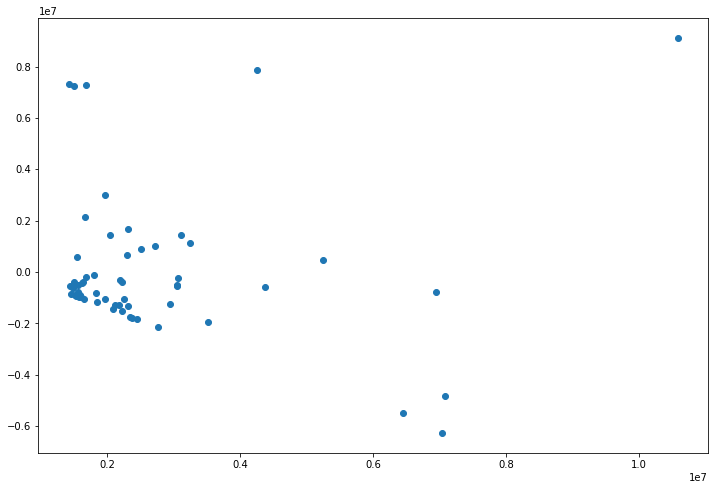

In [133]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(fit2.predict(), fit2.resid);

We can see from this plot that we don't have a strong linear model. Going back to our original dataset, we should look at some of the extreme outliers. Using some domain knowledge we see that the top three games from a streaming perspective are Fortnite, PUBG and Overwatch. These are free to play games (that had small console releases after the fact) so aren't really representative of real sales numbers. Let's take them out of the dataset and see what happens. 

In [136]:
# drop fortnite, PUBG and Overwatch
combined_2018 = combined_2018.drop([18, 34, 33])

Let's go back to our domain knowledge and the residuals above before we move on to different models and feature engineering. We can likely take out some more titles that are influencing the charts. 
- Rainbow Six Siege still sees huge numbers but came out in 2015 so let's take that out. 
- Similarly, Rocket League came out in 2014 yet is one of the top streamed games with small sales. 
- Finally, let's take out outdated sports games. We see just as high number for 2018 titles in streaming but lower sales compared to 2019 which came out in the year we are studying

In [138]:
# drop rainbow six, rocket league, sports games from 2017 releases and the older assassin's creed
combined_2018 = combined_2018.drop([1, 16, 30, 36, 55])

In [140]:
combined_2018.corr()

,yearly,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
yearly,1.000000,0.251051,0.171638,0.449244,0.465124,0.257978,0.251041,0.171691,-0.053747
watch_time,0.251051,1.000000,0.861905,0.380791,0.501167,0.871856,1.000000,0.862255,-0.001804
stream_time,0.171638,0.861905,1.000000,0.374619,0.649485,0.916378,0.861902,0.999997,-0.174557
peak_viewers,0.449244,0.380791,0.374619,1.000000,0.703985,0.451361,0.380790,0.374853,0.052579
peak_channels,0.465124,0.501167,0.649485,0.703985,1.000000,0.576450,0.501155,0.649575,-0.142791
streamers,0.257978,0.871856,0.916378,0.451361,0.576450,1.000000,0.871853,0.916445,-0.164439
average_viewers,0.251041,1.000000,0.861902,0.380790,0.501155,0.871853,1.000000,0.862253,-0.001837
average_channels,0.171691,0.862255,0.999997,0.374853,0.649575,0.916445,0.862253,1.000000,-0.174156
average_viewer_ratio,-0.053747,-0.001804,-0.174557,0.052579,-0.142791,-0.164439,-0.001837,-0.174156,1.000000


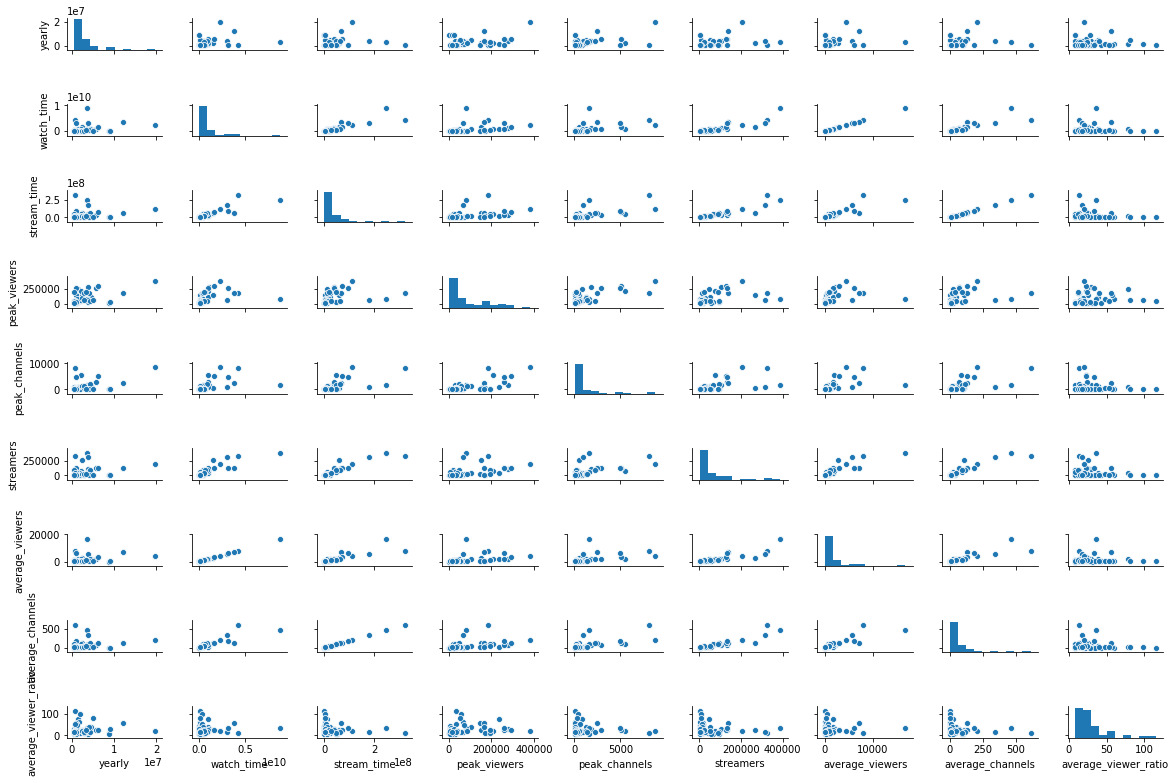

In [142]:
sns.pairplot(combined_2018, height=1.2, aspect=1.5);

In [143]:
# Define the model
lm1 = smf.ols('yearly ~ watch_time + stream_time + peak_viewers + peak_channels + streamers + average_viewers + average_channels + average_viewer_ratio', data=combined_2018)

# Fit the model
fit3 = lm1.fit()

# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     3.012
Date:                Thu, 18 Jul 2019   Prob (F-statistic):            0.00938
Time:                        22:50:28   Log-Likelihood:                -813.20
No. Observations:                  50   AIC:                             1644.
Df Residuals:                      41   BIC:                             1662.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept             1.254e+06   1.34e+06      0.935      0.355   -1.45e+06    3.96e+06
watch_time               1.5995      3.258      0.491      0.626      -4.980       8.179
stream_time              1.4349      3.043      0.472      0.640      -4.710       7.580
peak_viewers             1.7719      7.829      0.226      0.822     -14.040      17.584
peak_channels         1127.3201    444.502      2.536      0.015     229.630    2025.010
streamers               16.3236     14.831      1.101      0.277     -13.629      46.276
average_viewers        -8.4e+05   1.71e+06     -0.491      0.626    -4.3e+06    2.62e+06
average_channels     -7.867e+05    1.6e+06     -0.491      0.626   -4.02e+06    2.45e+06
average_viewer_ratio  -1.51e+04   2.32e+04     -0.650      0.519    -6.2e+04    3.18e+04
==============================================================================
Omnibus:                       13.194   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.404
Skew:                           1.051   Prob(JB):                     0.000745
Kurtosis:                       4.580   Cond. No.                     7.41e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.41e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

And again let's take out the highest P values.

In [144]:
# Define the model
lm1 = smf.ols('yearly ~ stream_time + peak_channels + streamers + average_channels', data=combined_2018)

# Fit the model
fit4 = lm1.fit()

# Print summary statistics of the model's performance
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yearly   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.265
Method:                 Least Squares   F-statistic:                     5.417
Date:                Thu, 18 Jul 2019   Prob (F-statistic):            0.00120
Time:                        22:52:07   Log-Likelihood:                -814.93
No. Observations:                  50   AIC:                             1640.
Df Residuals:                      45   BIC:                             1649.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.523e+06   9.03e+05      1.687      0.099   -2.96e+05    3.34e+06
stream_time          0.4536      2.832      0.160      0.873      -5.251       6.158
peak_channels     1146.2996    291.289      3.935      0.000     559.613    1732.986
streamers           27.5763     11.997      2.299      0.026       3.414      51.739
average_channels -2.651e+05   1.49e+06     -0.178      0.860   -3.27e+06    2.73e+06
==============================================================================
Omnibus:                       17.166   Durbin-Watson:                   1.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.616
Skew:                           1.314   Prob(JB):                     3.34e-05
Kurtosis:                       4.730   Cond. No.                     2.74e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.74e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

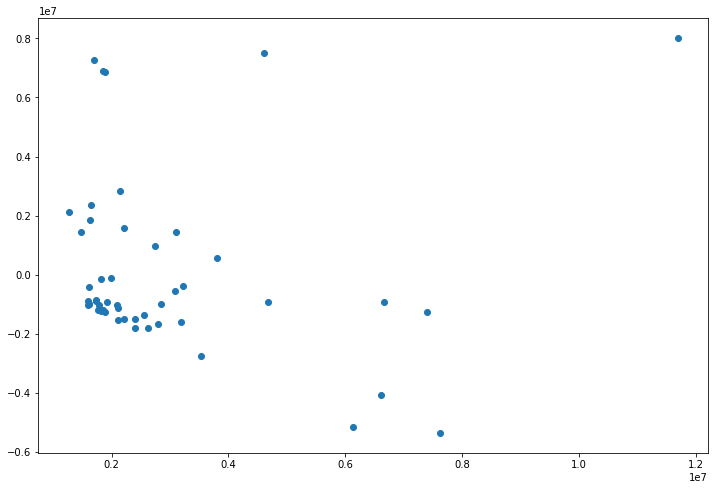

In [145]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(fit4.predict(), fit4.resid);

Frustratingly, (but perhaps not surprisingly) we see the same patterns as before. However, also once again notice the exceptionally high peak_channels coefficient. Now for each singular change in peak_channels in the positive, we see over a 1K positive change in unit sales. That is absolutely significant!

Before we abandon this hypothesis, let's now look at monthly sales and see if we see any significant relationship between the features and target when we look at the first 4 weeks of release only.

## Part IV. Month to Month

### January

In [219]:
# bring in vg chart data from url
url = 'http://www.vgchartz.com/weekly/43128/Global/'

response = requests.get(url)

In [220]:
tables = pd.read_html(url)

In [221]:
# convert list object to a dataframe 
jan_df = pd.DataFrame(tables[1])

In [222]:
# Apply a function to format game title 
jan_df['Game'] = jan_df['Game'].apply(game_title)

In [223]:
# lower case the game rows so that they are compatible with Twitch dataframe
jan_df['Game'] = jan_df['Game'].str.lower()

In [224]:
# format columns in lowercase
jan_df.columns = [x.lower() for x in jan_df.columns]

In [225]:
jan_filtered =  jan_df.loc[jan_df['week #'] <=4]


In [226]:
# drop all rows in which release date is a NaN
jan_filtered = jan_filtered.dropna(subset=['total'])

In [227]:
jan_df = jan_filtered.groupby(['game'])['total'].sum().reset_index()


In [228]:
jan_df

,game,total
0,dragon ball fighter z,555081.0
1,monster hunter: world,2475315.0
2,pokemon crystal version,22071.0
3,the inpatient,44768.0


In [229]:
jan_df['game'] = jan_df['game'].replace(['dragon ball fighter z'], 'dragon ball fighterz')

In [230]:
jan_df['game'] = jan_df['game'].replace(['monster hunter: world'], 'monster hunter world')

In [231]:
jan_df['game'] = jan_df['game'].replace(['pokemon crystal version'], 'pokémon crystal')


In [232]:
twitch_jan = pd.read_csv("twitch_january")

In [233]:
twitch_jan.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [234]:
twitch_jan = twitch_jan.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [235]:
twitch_jan['game'] = twitch_jan['game'].str.lower()

In [236]:
combined_jan = pd.merge(jan_df, twitch_jan, on='game')

In [237]:
combined_jan

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,dragon ball fighterz,555081.0,252120180,6096480,50130,1894,23980,5655,136,41.36
1,monster hunter world,2475315.0,740393160,13561920,169921,2525,56100,16608,304,54.59
2,the inpatient,44768.0,6857760,44460,35578,19,330,153,0,154.25


## February 

In [238]:
# bring in vg chart data from url
url = 'http://www.vgchartz.com/weekly/43156/Global/'

response = requests.get(url)

In [239]:
tables = pd.read_html(url)

In [240]:
# convert list object to a dataframe 
feb_df = pd.DataFrame(tables[1])

In [241]:
# Apply a function to format game title 
feb_df['Game'] = feb_df['Game'].apply(game_title)

In [242]:
# lower case the game rows so that they are compatible with Twitch dataframe
feb_df['Game'] = feb_df['Game'].str.lower()

In [243]:
# format columns in lowercase
feb_df.columns = [x.lower() for x in feb_df.columns]

In [244]:
feb_filtered =  feb_df.loc[feb_df['week #'] <=4]

In [245]:
# drop all rows in which release date is a NaN
feb_filtered = feb_filtered.dropna(subset=['total'])

In [246]:
feb_df = feb_filtered.groupby(['game'])['total'].sum().reset_index()


In [247]:
feb_df

,game,total
0,bayonetta 2,236650.0
1,dynasty warriors 9,221284.0
2,ea sports ufc 3,373854.0
3,girls und panzer: dream tank match,42160.0
4,kingdom come: deliverance,266058.0
5,metal gear survive,83951.0
6,secret of mana,149875.0
7,senran kagura burst re:newal,25091.0
8,shadow of the colossus,596178.0
9,sword art online: fatal bullet,154942.0


In [248]:
twitch_feb = pd.read_csv("twitch_february") 

In [249]:
twitch_feb.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [250]:
twitch_feb = twitch_feb.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [251]:
twitch_feb['game'] = twitch_feb['game'].str.lower()

In [252]:
combined_feb = pd.merge(feb_df, twitch_feb, on='game')

In [253]:
combined_feb

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,bayonetta 2,236650.0,5414580,170940,6439,28,470,134,4,31.68
1,dynasty warriors 9,221284.0,12164340,791520,7026,129,1786,302,19,15.37
2,ea sports ufc 3,373854.0,56193840,531120,44939,44,4158,1395,13,105.80
3,girls und panzer: dream tank match,42160.0,2733420,25380,8827,19,79,67,0,107.70
4,kingdom come: deliverance,266058.0,634765020,11278140,211281,1561,20465,15766,280,56.28
5,metal gear survive,83951.0,47458440,1882440,44890,331,4957,1178,46,25.21
6,secret of mana,149875.0,25836540,1515300,9936,407,3907,641,37,17.05
7,shadow of the colossus,596178.0,184264560,2623560,69742,521,10414,4576,65,70.23
8,sword art online: fatal bullet,154942.0,18921420,1796040,35909,585,4768,469,44,10.54


## March

In [254]:
# bring in vg chart data from url
url = 'http://www.vgchartz.com/weekly/43191/Global/'

response = requests.get(url)

In [255]:
tables = pd.read_html(url)

In [256]:
# convert list object to a dataframe 
mar_df = pd.DataFrame(tables[1])

In [257]:
# Apply a function to format game title 
mar_df['Game'] = mar_df['Game'].apply(game_title)

In [258]:
# lower case the game rows so that they are compatible with Twitch dataframe
mar_df['Game'] = mar_df['Game'].str.lower()

In [259]:
# format columns in lowercase
mar_df.columns = [x.lower() for x in mar_df.columns]

In [260]:
mar_filtered =  mar_df.loc[mar_df['week #'] <=5]

In [261]:
# drop all rows in which release date is a NaN
mar_filtered = mar_filtered.dropna(subset=['total'])

In [262]:
mar_df = mar_filtered.groupby(['game'])['total'].sum().reset_index()


In [263]:
mar_df

,game,total
0,a way out,143994.0
1,far cry 5,2465970.0
2,great detective pikachu,158998.0
3,kirby,878071.0
4,mlb the show 18,412691.0
5,mx vs atv all out,27203.0
6,ni no kuni ii: revenant kingdom,364385.0
7,sea of thieves,337986.0
8,super robot wars x,142093.0


In [264]:
mar_df['game'] = mar_df['game'].replace(['kirby'], 'kirby: star allies')

In [265]:
mar_df['game'] = mar_df['game'].replace(['great detective pikachu'], 'detective pikachu')

In [266]:
twitch_mar = pd.read_csv("twitch_march")

In [267]:
twitch_mar.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [268]:
twitch_mar = twitch_mar.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [269]:
twitch_mar['game'] = twitch_mar['game'].str.lower()

In [270]:
combined_mar = pd.merge(mar_df, twitch_mar, on='game')

In [271]:
combined_mar

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,a way out,143994.0,325389720,5382300,233484,1587,21244,7299,120,60.46
1,far cry 5,2465970.0,613083180,11496480,258270,2864,46193,13752,257,53.33
2,detective pikachu,158998.0,3633240,43320,2262,21,149,81,0,83.87
3,kirby: star allies,878071.0,23374020,559020,24135,186,1985,524,12,41.81
4,mlb the show 18,412691.0,23535600,601500,8924,199,3965,527,13,39.13
5,ni no kuni ii: revenant kingdom,364385.0,57513840,2437980,30369,528,6872,1290,54,23.59
6,sea of thieves,337986.0,934015560,32591880,255998,4908,66327,20951,731,28.66
7,super robot wars x,142093.0,5171460,139980,2901,63,178,116,3,36.94


## April 

In [272]:
# bring in vg chart data from url
url = 'http://www.vgchartz.com/weekly/43219/Global/'

response = requests.get(url)

In [273]:
tables = pd.read_html(url)

In [274]:
apr_df = pd.DataFrame(tables[1])

In [275]:
apr_df['Game'] = apr_df['Game'].apply(game_title)

In [276]:
apr_df['Game'] = apr_df['Game'].str.lower()

In [277]:
apr_df.columns = [x.lower() for x in apr_df.columns]

In [278]:
apr_filtered =  apr_df.loc[apr_df['week #'] <=4]

In [279]:
apr_filtered = apr_filtered.dropna(subset=['total'])

In [280]:
apr_df = apr_filtered.groupby(['game'])['total'].sum().reset_index()


In [281]:
apr_df

,game,total
0,god of war,3042262.0
1,jikkyou powerful pro baseball 2018,187515.0
2,nintendo labo: toy-con 01 variety kit,321130.0
3,nintendo labo: toy-con 02 robot kit,102791.0
4,rick & morty virtual rick-ality,37850.0
5,south park: the fractured but whole,24599.0
6,utawarerumono: chiriyukusha e no komoriuta,19593.0


In [282]:
apr_df['game'] = apr_df['game'].replace(['nintendo labo: toy-con 01 variety kit'], 'nintendo labo variety kit')

In [283]:
apr_df['game'] = apr_df['game'].replace(['nintendo labo: toy-con 02 robot kit'], 'nintendo labo robot kit')

In [284]:
apr_df['game'] = apr_df['game'].replace(['rick & morty virtual rick-ality'], 'rick & morty: virtual rick-ality')

In [285]:
twitch_apr = pd.read_csv("twitch_april")

In [286]:
twitch_apr.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [287]:
twitch_apr = twitch_apr.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [288]:
twitch_apr['game'] = twitch_apr['game'].str.lower()

In [289]:
combined_apr = pd.merge(apr_df, twitch_apr, on='game')

In [290]:
combined_apr

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,god of war,3042262.0,1218101340,32574000,292083,5006,67022,28236,755,37.39
1,nintendo labo variety kit,321130.0,10797480,62400,26615,29,238,250,1,173.04


## May

In [291]:
# bring in vg chart data from url
url = 'http://www.vgchartz.com/weekly/43247/Global/'

response = requests.get(url)

In [292]:
tables = pd.read_html(url)

In [293]:
may_df = pd.DataFrame(tables[1])

In [294]:
may_df['Game'] = may_df['Game'].apply(game_title)

In [295]:
may_df['Game'] = may_df['Game'].str.lower()

In [296]:
may_df.columns = [x.lower() for x in may_df.columns]

In [297]:
may_filtered =  may_df.loc[may_df['week #'] <=4]

In [298]:
may_filtered = may_filtered.dropna(subset=['total'])

In [299]:
may_df = may_filtered.groupby(['game'])['total'].sum().reset_index()


In [300]:
may_df

,game,total
0,dark souls: remastered,231158.0
1,detroit: become human,407765.0
2,donkey kong country: tropical freeze,606107.0
3,mega man legacy collection 1+2,44223.0
4,persona dancing: all-star triple pack,27909.0
5,state of decay 2,177473.0


In [301]:
may_df['game'] = may_df['game'].replace(['dark souls: remastered'], 'dark souls')

In [302]:
twitch_may = pd.read_csv("twitch_may")

In [303]:
twitch_may.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [304]:
twitch_may = twitch_may.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [305]:
twitch_may['game'] = twitch_may['game'].str.lower()

In [306]:
combined_may = pd.merge(may_df, twitch_may, on='game')

In [307]:
combined_may

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,dark souls,231158.0,359867760,6330300,103455,871,14997,8072,141,56.85
1,detroit: become human,407765.0,565958400,3794520,236767,856,16222,12695,85,149.15
2,donkey kong country: tropical freeze,606107.0,23170500,458280,35683,74,1445,519,10,50.56
3,state of decay 2,177473.0,207823440,8028660,84104,1197,23308,4661,180,25.89


## June

In [308]:
# bring in vg chart data from url
url = 'http://www.vgchartz.com/weekly/43282/Global/'

response = requests.get(url)

In [309]:
tables = pd.read_html(url)

In [310]:
june_df = pd.DataFrame(tables[1])

In [311]:
june_df['Game'] = june_df['Game'].apply(game_title)

In [312]:
june_df['Game'] = june_df['Game'].str.lower()

In [313]:
june_df.columns = [x.lower() for x in june_df.columns]

In [314]:
june_filtered =  june_df.loc[june_df['week #'] <=5]

In [315]:
june_filtered = june_filtered.dropna(subset=['total'])

In [316]:
june_df = june_filtered.groupby(['game'])['total'].sum().reset_index()


In [317]:
june_df['game'] = june_df['game'].replace(['crash bandicoot n. sane trilogy'], 'crash bandicoot: n. sane trilogy')

In [318]:
june_df

,game,total
0,crash bandicoot: n. sane trilogy,138741.0
1,crash bandicoot n.sane trilogy,86401.0
2,harvest moon: light of hope,75769.0
3,mario tennis aces,689572.0
4,minecraft,166263.0
5,the crew 2,282710.0
6,wolfenstein ii: the new colossus,31708.0
7,ys viii: lacrimosa of dana,23530.0


In [319]:
twitch_june = pd.read_csv("twitch_june")

In [320]:
twitch_june.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [321]:
twitch_june = twitch_june.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [322]:
twitch_june['game'] = twitch_june['game'].str.lower()

In [323]:
combined_june = pd.merge(june_df, twitch_june, on='game')

In [324]:
combined_june

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,crash bandicoot: n. sane trilogy,138741.0,15318780,498720,119032,290,3685,355,11,30.72
1,mario tennis aces,689572.0,179868000,1388040,56535,348,4532,4169,32,129.58
2,minecraft,166263.0,184778640,14051100,27186,552,43784,4283,325,13.15
3,the crew 2,282710.0,60096060,2866800,37298,510,12091,1393,66,20.96


## July

In [325]:
url = 'http://www.vgchartz.com/weekly/43310/Global/'

response = requests.get(url)

In [326]:
tables = pd.read_html(url)

In [327]:
july_df = pd.DataFrame(tables[1])

In [328]:
july_df['Game'] = july_df['Game'].apply(game_title)

In [329]:
july_df['Game'] = july_df['Game'].str.lower()

In [330]:
july_df.columns = [x.lower() for x in july_df.columns]

In [331]:
july_filtered =  july_df.loc[july_df['week #'] <=4]

In [332]:
july_filtered = july_filtered.dropna(subset=['total'])

In [333]:
july_df = july_filtered.groupby(['game'])['total'].sum().reset_index()


In [334]:
july_df['game'] = july_df['game'].replace(['project octopath traveler'], 'octopath traveler')

In [335]:
july_df

,game,total
0,captain toad: treasure tracker,276315.0
1,go vacation,32307.0
2,hello neighbor,45421.0
3,mega man legacy collection 1+2,52911.0
4,no man's sky,29879.0
5,octopath traveler,513829.0
6,taiko no tatsujin: drum 'n' fun!,99005.0
7,train sim world,23673.0


In [336]:
twitch_july = pd.read_csv("twitch_july")  

In [337]:
twitch_july.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [338]:
twitch_july = twitch_july.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [339]:
twitch_july['game'] = twitch_july['game'].str.lower()

In [340]:
combined_july = pd.merge(july_df, twitch_july, on='game')

In [341]:
combined_july

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,captain toad: treasure tracker,276315.0,9925140,149400,4656,28,581,222,3,66.43
1,hello neighbor,45421.0,13945260,97500,18897,15,611,312,2,143.03
2,no man's sky,29879.0,256753740,8097960,118853,1264,23669,5759,181,31.71
3,octopath traveler,513829.0,112760580,2892540,41085,360,4240,2529,64,38.98


## August

In [342]:
url = 'http://www.vgchartz.com/weekly/43338/Global/'

response = requests.get(url)

In [343]:
tables = pd.read_html(url)

In [344]:
aug_df = pd.DataFrame(tables[1])

In [345]:
aug_df['Game'] = aug_df['Game'].apply(game_title)

In [346]:
aug_df['Game'] = aug_df['Game'].str.lower()

In [347]:
aug_df.columns = [x.lower() for x in aug_df.columns]

In [348]:
aug_filtered =  aug_df.loc[aug_df['week #'] <=4]

In [349]:
aug_filtered = aug_filtered.dropna(subset=['total'])

In [350]:
aug_df = aug_filtered.groupby(['game'])['total'].sum().reset_index()


In [351]:
aug_df

,game,total
0,f1 2018,169955.0
1,little dragon cafe,16994.0
2,madden nfl 19,1306224.0
3,my hero one's justice,39520.0
4,shenmue i & ii,107971.0


In [352]:
twitch_aug = pd.read_csv("twitch_august")  

In [353]:
twitch_aug.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [354]:
twitch_aug = twitch_aug.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [355]:
twitch_aug['game'] = twitch_aug['game'].str.lower()

In [356]:
combined_aug = pd.merge(aug_df, twitch_aug, on='game')

In [357]:
combined_aug

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,f1 2018,169955.0,11731620,433500,6979,111,2533,263,9,27.06
1,madden nfl 19,1306224.0,160112280,13031460,25629,1560,32300,3591,292,12.29
2,shenmue i & ii,107971.0,22474980,385560,10227,97,889,504,8,58.29


## September

In [358]:
url = 'http://www.vgchartz.com/weekly/43373/Global/'

response = requests.get(url)

In [359]:
tables = pd.read_html(url)

In [360]:
sept_df = pd.DataFrame(tables[1])

In [361]:
sept_df['Game'] = sept_df['Game'].apply(game_title)

In [362]:
sept_df['Game'] = sept_df['Game'].str.lower()

In [363]:
sept_df.columns = [x.lower() for x in sept_df.columns]

In [364]:
sept_filtered = sept_df.loc[sept_df['week #'] <=5]

In [365]:
sept_filtered = sept_filtered.dropna(subset=['total'])

In [366]:
sept_df = sept_filtered.groupby(['game'])['total'].sum().reset_index()


In [367]:
sept_df

,game,total
0,dragon ball fighterz,103091.0
1,fifa 19,4294363.0
2,nba 2k19,1886150.0
3,shadow of the tomb raider,1195802.0
4,spider-man,4650930.0
5,the legend of heroes: trails of cold steel iv,95709.0
6,valkyria chronicles 4,186644.0
7,warriors orochi 4,127273.0


In [368]:
twitch_sept = pd.read_csv("twitch_september")  

In [369]:
twitch_sept.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [370]:
twitch_sept = twitch_sept.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [371]:
twitch_sept['game'] = twitch_sept['game'].str.lower()

In [372]:
combined_sept = pd.merge(sept_df, twitch_sept, on='game')

In [373]:
combined_sept = combined_sept.drop(combined_sept.index[4])

In [374]:
combined_sept

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,dragon ball fighterz,103091.0,69391020,1881960,25692,153,7785,1608,43,36.87
1,fifa 19,4294363.0,612806580,9766080,108755,2400,34539,14205,226,62.75
2,nba 2k19,1886150.0,324998820,18860220,47830,2267,44194,7533,437,17.23
3,shadow of the tomb raider,1195802.0,216507000,8367660,83572,1241,18142,5018,193,25.87
5,spider-man,4650930.0,3063720,265920,13522,37,1060,71,6,11.52
6,valkyria chronicles 4,186644.0,12889440,466260,8097,136,1021,298,10,27.64
7,warriors orochi 4,127273.0,9123000,32400,8974,13,68,211,0,281.57


## October

In [375]:
# bring in vg chart data from url
url = 'http://www.vgchartz.com/weekly/43401/Global/'

response = requests.get(url)

In [376]:
tables = pd.read_html(url)

In [377]:
# convert list object to a dataframe 
oct_df = pd.DataFrame(tables[1])

In [378]:
# Apply a function to format game title 
oct_df['Game'] = oct_df['Game'].apply(game_title)

In [379]:
# lower case the game rows so that they are compatible with Twitch dataframe
oct_df['Game'] = oct_df['Game'].str.lower()

In [380]:
# format columns in lowercase
oct_df.columns = [x.lower() for x in oct_df.columns]

In [381]:
oct_filtered =  oct_df.loc[oct_df['week #'] <=4]



In [382]:
# drop all rows in which release date is a NaN
oct_filtered = oct_filtered.dropna(subset=['total'])

In [383]:
oct_df = oct_filtered.groupby(['game'])['total'].sum().reset_index()


In [384]:
oct_df

,game,total
0,assassin's creed odyssey,2365366.0
1,call of duty: black ops iiii,6649960.0
2,dark souls: remastered,139431.0
3,forza horizon 4,793463.0
4,lego dc super-villains,119272.0
5,luigi's mansion,120248.0
6,my hero one's justice,45044.0
7,red dead redemption 2,6233893.0
8,soulcalibur vi,559664.0
9,super mario party,1342261.0


In [385]:
oct_df['game'] = oct_df['game'].replace(['dark souls: remastered'], 'dark souls')

In [386]:
twitch_oct = pd.read_csv("twitch_october")

In [387]:
twitch_oct.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [388]:
twitch_oct = twitch_oct.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [389]:
twitch_oct['game'] = twitch_oct['game'].str.lower()

In [390]:
combined_oct = pd.merge(oct_df, twitch_oct, on='game')

In [391]:
combined_oct

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,assassin's creed odyssey,2365366.0,823655280,16107900,105475,1221,34860,18475,361,51.13
1,dark souls,139431.0,36624900,1636800,12864,88,3953,821,36,22.38
2,forza horizon 4,793463.0,89881500,7280400,20354,654,23973,2016,163,12.35
3,lego dc super-villains,119272.0,3454080,70320,15495,16,408,77,1,49.12
4,luigi's mansion,120248.0,3716280,257040,1490,42,962,83,5,14.46
5,my hero one's justice,45044.0,8199960,456540,11617,145,1608,183,10,17.96
6,red dead redemption 2,6233893.0,1171822980,34018260,382860,8785,88742,26285,763,34.45
7,soulcalibur vi,559664.0,171428460,2774280,35806,555,7727,3845,62,61.79
8,super mario party,1342261.0,94373280,1012080,52103,319,3943,2116,22,93.25
9,wwe 2k19,362802.0,41414580,2099040,33453,228,4693,928,47,19.73


## November

In [392]:
url = 'http://www.vgchartz.com/weekly/43429/Global/'

response = requests.get(url)

In [393]:
tables = pd.read_html(url)

In [394]:
nov_df = pd.DataFrame(tables[1])

In [395]:
nov_df['Game'] = nov_df['Game'].apply(game_title)

In [396]:
nov_df['Game'] = nov_df['Game'].str.lower()

In [397]:
nov_df.columns = [x.lower() for x in nov_df.columns]

In [398]:
nov_filtered = nov_df.loc[nov_df['week #'] <=4]

In [399]:
nov_filtered = nov_filtered.dropna(subset=['total'])

In [400]:
nov_df = nov_filtered.groupby(['game'])['total'].sum().reset_index()

In [401]:
nov_df['game'] = nov_df['game'].replace(["pokemon: let's go, eevee!"], "pokemon: let's go, pikachu!/eevee!")

In [402]:
nov_df['game'] = nov_df['game'].replace(["pokemon: let's go, pikachu!"], "pokemon: let's go, pikachu!/eevee!")

In [403]:
nov_df = nov_filtered.groupby(['game'])['total'].sum().reset_index()


In [404]:
nov_df

,game,total
0,battlefield v,1368049.0
1,fallout 76,1337315.0
2,farming simulator 19,514670.0
3,"pokemon: let's go, eevee!",1504323.0
4,"pokemon: let's go, pikachu!",2297797.0
5,spyro reignited trilogy,1199596.0


In [405]:
twitch_nov = pd.read_csv("twitch_november")  

In [406]:
twitch_nov.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [407]:
twitch_nov = twitch_nov.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [408]:
twitch_nov['game'] = twitch_nov['game'].str.lower()

In [409]:
combined_nov = pd.merge(nov_df, twitch_nov, on='game')

In [410]:
combined_nov

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,battlefield v,1368049.0,499377600,15136800,89149,1160,46471,11575,350,32.99
1,fallout 76,1337315.0,812623020,32799240,209140,5476,59684,18836,760,24.78
2,farming simulator 19,514670.0,120410340,4095660,42848,783,7556,2791,94,29.40
3,spyro reignited trilogy,1199596.0,111451320,6500100,58334,1346,17693,2583,150,17.15


## December

In [411]:
url = 'http://www.vgchartz.com/weekly/43464/Global/'

response = requests.get(url)

In [412]:
tables = pd.read_html(url)

In [413]:
dec_df = pd.DataFrame(tables[1])

In [414]:
dec_df['Game'] = dec_df['Game'].apply(game_title)

In [415]:
dec_df['Game'] = dec_df['Game'].str.lower()

In [416]:
dec_df.columns = [x.lower() for x in dec_df.columns]

In [417]:
dec_filtered = dec_df.loc[dec_df['week #'] <=5]

In [418]:
dec_filtered = dec_filtered.dropna(subset=['total'])

In [419]:
dec_df = dec_filtered.groupby(['game'])['total'].sum().reset_index()


In [420]:
dec_df

,game,total
0,just cause 4,558661.0
1,super smash bros.,8951009.0


In [421]:
# dec_df.at['game', 'super smash bros.'] = 'super smash bros. ultimate'
#dec_df['1']['game'] = 'super smash bros. ultimate'
dec_df.at['1', 'game'] = 'super smash bros. ultimate'


In [422]:
dec_df = dec_df.fillna(value=8951009.0)


In [423]:
twitch_dec = pd.read_csv("twitch_december")  

In [424]:
twitch_dec.rename(columns = {
    'Game': 'game',
    'Watch time': 'watch_time',
    'Stream time': 'stream_time',
    'Peak viewers': 'peak_viewers',
    'Peak channels': 'peak_channels',
    'Streamers': 'streamers',
    'Average viewers': 'average_viewers',
    'Average channels': 'average_channels',
    'Average viewer ratio': 'average_viewer_ratio',
    'Followers gained': 'followers_gained',
    'Views gained': 'views_gained'},
    inplace = True)

In [425]:
twitch_dec = twitch_dec.drop(['followers_gained', 'Unnamed: 1', 'Unnamed: 0', 'Unnamed: 13', 'views_gained'], axis=1)


In [426]:
twitch_dec['game'] = twitch_dec['game'].str.lower()

In [427]:
combined_dec = pd.merge(dec_df, twitch_dec, on='game')

In [428]:
combined_dec

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,just cause 4,558661.0,103193340,1552980,39081,279,5800,2314,34,66.45
1,super smash bros. ultimate,8951009.0,1459988040,20591220,226029,3619,33515,32749,461,70.90


### Combining. Finally!!

In [429]:
df_2018 = pd.concat([combined_jan, combined_feb, combined_mar, combined_apr, combined_may, combined_june, combined_july, combined_aug, combined_sept, combined_oct, combined_nov, combined_dec], ignore_index=True) 

In [430]:
df_2018

,game,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
0,dragon ball fighterz,555081.0,252120180,6096480,50130,1894,23980,5655,136,41.36
1,monster hunter world,2475315.0,740393160,13561920,169921,2525,56100,16608,304,54.59
2,the inpatient,44768.0,6857760,44460,35578,19,330,153,0,154.25
3,bayonetta 2,236650.0,5414580,170940,6439,28,470,134,4,31.68
4,dynasty warriors 9,221284.0,12164340,791520,7026,129,1786,302,19,15.37
5,ea sports ufc 3,373854.0,56193840,531120,44939,44,4158,1395,13,105.80
6,girls und panzer: dream tank match,42160.0,2733420,25380,8827,19,79,67,0,107.70
7,kingdom come: deliverance,266058.0,634765020,11278140,211281,1561,20465,15766,280,56.28
8,metal gear survive,83951.0,47458440,1882440,44890,331,4957,1178,46,25.21
9,secret of mana,149875.0,25836540,1515300,9936,407,3907,641,37,17.05


### Correlations and Models

Now, let's again plot the correlations

In [431]:
df_2018.corr()

,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
total,1.000000,0.724379,0.550515,0.535575,0.625395,0.542128,0.718130,0.544623,-0.074400
watch_time,0.724379,1.000000,0.875606,0.878300,0.857683,0.844562,0.999559,0.873452,-0.049045
stream_time,0.550515,0.875606,1.000000,0.780134,0.925361,0.952514,0.876954,0.999679,-0.228196
peak_viewers,0.535575,0.878300,0.780134,1.000000,0.854148,0.793901,0.878763,0.778029,-0.010637
peak_channels,0.625395,0.857683,0.925361,0.854148,1.000000,0.908435,0.856290,0.922001,-0.173152
streamers,0.542128,0.844562,0.952514,0.793901,0.908435,1.000000,0.843930,0.950279,-0.230181
average_viewers,0.718130,0.999559,0.876954,0.878763,0.856290,0.843930,1.000000,0.875503,-0.050163
average_channels,0.544623,0.873452,0.999679,0.778029,0.922001,0.950279,0.875503,1.000000,-0.229450
average_viewer_ratio,-0.074400,-0.049045,-0.228196,-0.010637,-0.173152,-0.230181,-0.050163,-0.229450,1.000000


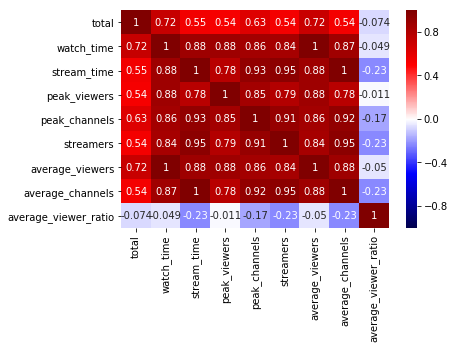

In [432]:
sns.heatmap(df_2018.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


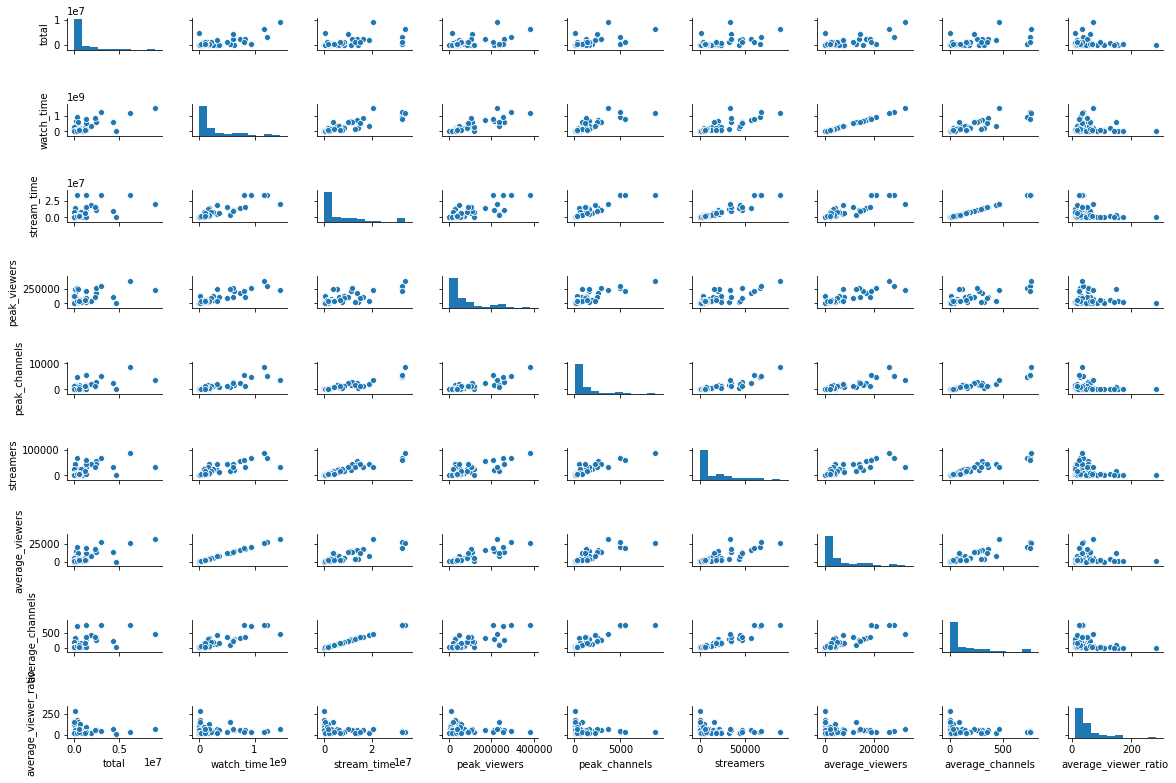

In [433]:
# Plot all of the variable-to-variable relations as scatterplots
sns.pairplot(df_2018, height=1.2, aspect=1.5);

This is a bit more encouraging! We see now some signal strength between our features and target as well as a bit more of a linear relationship in the pair plots. Let's run through our typical iteration process and see what our coefficients and R2 look like!

In [437]:
# Define the model
lm1 = smf.ols('total ~ watch_time + stream_time + peak_viewers + peak_channels + streamers + average_viewers + average_channels', data=df_2018)

# Fit the model
fit = lm1.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     19.50
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           1.61e-12
Time:                        23:12:40   Log-Likelihood:                -903.15
No. Observations:                  60   AIC:                             1822.
Df Residuals:                      52   BIC:                             1839.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.617e+05   1.65e+05      3.413      0.001    2.31e+05    8.92e+05
watch_time           0.0481      0.033      1.439      0.156      -0.019       0.115
stream_time         -1.7151      1.553     -1.105      0.274      -4.831       1.400
peak_viewers       -15.5512      3.487     -4.460      0.000     -22.549      -8.554
peak_channels     1052.7023    245.665      4.285      0.000     559.740    1545.664
streamers           12.5555     20.007      0.628      0.533     -27.591      52.701
average_viewers  -1803.7884   1474.038     -1.224      0.227   -4761.663    1154.086
average_channels  6.531e+04   6.75e+04      0.967      0.338   -7.02e+04    2.01e+05
==============================================================================
Omnibus:                       50.097   Durbin-Watson:                   1.722
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              291.057
Skew:                           2.179   Prob(JB):                     6.28e-64
Kurtosis:                      12.871   Cond. No.                     5.91e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Much better than before! But we can do even better. Let's take out those high P values!

In [438]:
# Define the model
lm1 = smf.ols('total ~ watch_time + peak_viewers + peak_channels + average_channels', data=df_2018)

# Fit the model
fit2 = lm1.fit()

# Print summary statistics of the model's performance
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.693
Method:                 Least Squares   F-statistic:                     34.29
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           2.37e-14
Time:                        23:14:59   Log-Likelihood:                -904.26
No. Observations:                  60   AIC:                             1819.
Df Residuals:                      55   BIC:                             1829.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         5.575e+05   1.57e+05      3.544      0.001    2.42e+05    8.73e+05
watch_time           0.0072      0.001      7.790      0.000       0.005       0.009
peak_viewers       -15.7965      3.255     -4.853      0.000     -22.320      -9.273
peak_channels     1057.4965    224.590      4.709      0.000     607.407    1507.586
average_channels -8764.6677   1727.225     -5.074      0.000   -1.22e+04   -5303.231
==============================================================================
Omnibus:                       48.061   Durbin-Watson:                   1.721
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              253.482
Skew:                           2.111   Prob(JB):                     9.06e-56
Kurtosis:                      12.141   Cond. No.                     5.69e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

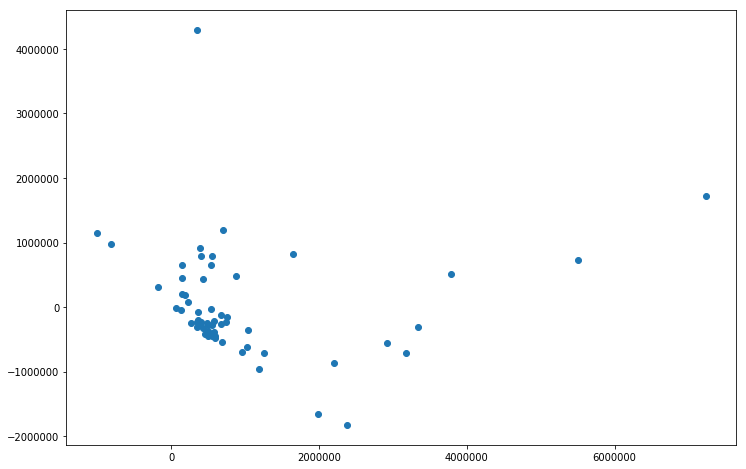

In [445]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(fit2.predict(), fit2.resid);

Well this isn't perfect, but we see an almost doubling of our R2 score and a bit more randomness on the residual plot. It's also worth noting that we still have over a 1000 positive multiplier in the peak_channels coefficient!

However, I think we could continue to experiment...

Going back up to the pairplots we see that they are heavily right-tailed. Let's perform a log transformation on the target and see if we can normalize that distribution.

In [446]:
df_2018['log_total'] = np.log(df_2018['total'])

In [449]:
# Define the model
lm1 = smf.ols('log_total ~ watch_time + stream_time + peak_viewers + peak_channels + streamers + average_viewers + average_channels', data=df_2018)

# Fit the model
fit3 = lm1.fit()

# Print summary statistics of the model's performance
fit3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_total   R-squared:                       0.509
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     7.693
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           2.32e-06
Time:                        23:21:31   Log-Likelihood:                -80.047
No. Observations:                  60   AIC:                             176.1
Df Residuals:                      52   BIC:                             192.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           12.4279      0.181     68.519      0.000      12.064      12.792
watch_time        2.148e-08   3.69e-08      0.582      0.563   -5.25e-08    9.55e-08
stream_time      -1.423e-06   1.71e-06     -0.832      0.409   -4.86e-06    2.01e-06
peak_viewers     -1.099e-05   3.84e-06     -2.860      0.006   -1.87e-05   -3.28e-06
peak_channels        0.0005      0.000      1.908      0.062   -2.67e-05       0.001
streamers         4.596e-05    2.2e-05      2.085      0.042    1.72e-06    9.02e-05
average_viewers     -0.0008      0.002     -0.468      0.641      -0.004       0.002
average_channels     0.0553      0.074      0.744      0.460      -0.094       0.205
==============================================================================
Omnibus:                        3.884   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.112
Skew:                           0.352   Prob(JB):                        0.211
Kurtosis:                       3.865   Cond. No.                     5.91e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.91e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [451]:
# Define the model
lm1 = smf.ols('log_total ~ peak_viewers + peak_channels + streamers', data=df_2018)


# Fit the model
fit4 = lm1.fit()

# Print summary statistics of the model's performance
fit4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_total   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     10.27
Date:                Thu, 18 Jul 2019   Prob (F-statistic):           1.74e-05
Time:                        23:22:48   Log-Likelihood:                -88.224
No. Observations:                  60   AIC:                             184.4
Df Residuals:                      56   BIC:                             192.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        12.3075      0.196     62.824      0.000      11.915      12.700
peak_viewers  -1.221e-06   3.14e-06     -0.389      0.699   -7.51e-06    5.07e-06
peak_channels     0.0002      0.000      0.958      0.342      -0.000       0.001
streamers      2.481e-05   1.65e-05      1.507      0.138   -8.18e-06    5.78e-05
==============================================================================
Omnibus:                        1.201   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.549   Jarque-Bera (JB):                0.539
Skew:                           0.080   Prob(JB):                        0.764
Kurtosis:                       3.436   Cond. No.                     1.61e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

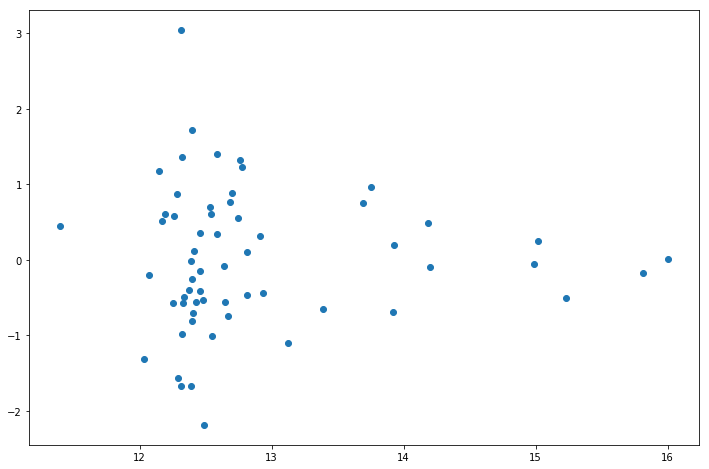

In [453]:
# Use statsmodels to plot the residuals vs the fitted values
plt.figure(figsize=(12,8))
plt.scatter(fit3.predict(), fit3.resid);

Although our R2 did go down, we see much more randomness on the residual plot. Still, I think we will go with our original model in the testing and validating phase as we are looking to maximize our R2 value.

## Regularization 

Because our model and recommendation is so incumbent upon the high coefficient value of peak_channels. Let's run the model through a LASSO regularization as a sanity check. LASSO essentially changes the cost function of a coefficient and penalizes it for being too large. It essentially forces large coefficients to be "worth it" for inclusion in our model.

In [489]:
#Split the data 60 - 20 - 20 train/val/test

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=.25, random_state=43)

In [492]:
lasso_model = Lasso(alpha = 1000) # this is our regularization strengtrh
lasso_model.fit(X_train, y_train)

Lasso(alpha=1000, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [493]:
list(zip(X, lasso_model.coef_))

[('watch_time', 0.007602706480127631),
 ('peak_viewers', -16.911860086163994),
 ('peak_channels', 890.3246713768239),
 ('average_channels', -6867.734356443916)]

Great. We can see that even with a rather high regularization strength on the alpha, our peak_channel coefficient is still significant.

## Part V. Split & Validate

We'll now begin working with scikit-learn for our splitting and validation phase. Let's redefine our variables so that the model hasn't "seen" the data as we move into this phase.

In [480]:
X = df_2018.loc[:,['watch_time', 'peak_viewers', 'peak_channels', 'average_channels']]
y = df_2018['total']


In [441]:
def split_and_validate(X, y):
    '''
    For a set of features and target X, y, perform a 80/20 train/val split, 
    fit and validate a linear regression model, and report results
    '''
    
    # perform train/val split
    X_train, X_val, y_train, y_val = \
        train_test_split(X, y, test_size=0.2)
    
    # fit linear regression to training data
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # score fit model on validation data
    val_score = lr_model.score(X_val, y_val)
    
    # this is used to compute adjusted r_squared
    val_score_2 = 1.0 - (1 - val_score) * (X_val.shape[0] - 1.) / (X_val.shape[0] - X_val.shape[1] - 1.)
    
    # report results
    print('\nValidation R^2 score was:', val_score)
    print('\nValidation Adj R^2 score was:', val_score_2)

    print('Feature coefficient results: \n')
    for feature, coef in zip(X.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}') 

In [442]:
# for 1st iteration with all columns (fit1)
split_and_validate(X, y)


Validation R^2 score was: 0.7701176478142595

Validation Adj R^2 score was: 0.6387563037081221
Feature coefficient results: 

watch_time : 0.01
peak_viewers : -13.67
peak_channels : 569.57
average_channels : -6580.40


These results are reasonably close to our model above. However, with such a small number of observations, we can expect to see considerable variance when we run this. We'll test that below in SK Learn. 

Before we do however, let's take a brief aside and see what is happening when we conduct a log and boxcox transformation on the target variable.

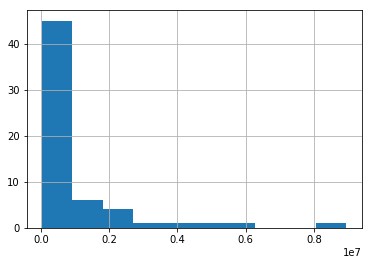

In [458]:
# create histogram
df_2018.total.hist();

# note the positive skew

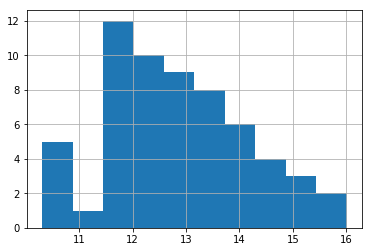

In [459]:
np.log(df_2018.total).hist();

# it looks better but not very "normal"

Lambda: -0.10939417765916534


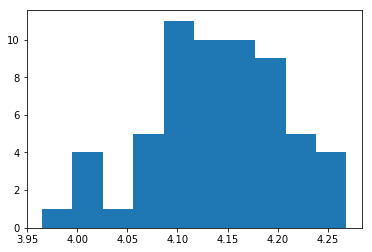

In [460]:
import scipy.stats as stats


# boxcox transformation on the distribution of total units
lamb=stats.boxcox_normmax(df_2018.total, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda:", lamb)
y_t=(np.power(df_2018.total,-0.2282)-1)/-0.2282

plt.hist(y_t);

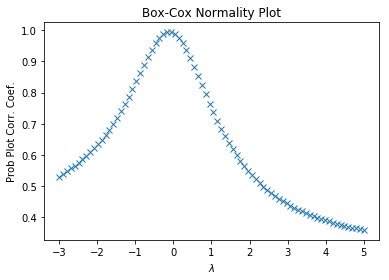

In [461]:
# plot to show optimal lambda values
fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(df_2018.total, -3, 5, plot=ax)

It's not a perfectly normal distribution, but it's a heck of a lot closer than we were before!

## Part VI. Train / Test / Split

To take us home, let's do a test in sk learn and also add in a few regularization models in there for fun to see how they compare with our vanilla regression model.

In [500]:
X = df_2018.loc[:,['watch_time', 'peak_viewers', 'peak_channels', 'average_channels']]
y = df_2018['total']

In [485]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge #ordinary linear regression + w/ ridge regularization
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

X, X_test, y, y_test = train_test_split(X, y, test_size=.2)

In [486]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.25)

In [1161]:
#set up the 3 models we're choosing from:

lm = LinearRegression()

#Feature scaling for train, val, and test so that we can run our ridge model on each
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.values)
X_val_scaled = scaler.transform(X_val.values)
X_test_scaled = scaler.transform(X_test.values)

lm_reg = Ridge(alpha=1)

#Feature transforms for train, val, and test so that we can run our poly model on each
poly = PolynomialFeatures(degree=2) 

X_train_poly = poly.fit_transform(X_train.values)
X_val_poly = poly.transform(X_val.values)
X_test_poly = poly.transform(X_test.values)

lm_poly = LinearRegression()

/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [1162]:
#validate

lm.fit(X_train, y_train)
print(f'Linear Regression val R^2: {lm.score(X_val, y_val):.3f}')

lm_reg.fit(X_train_scaled, y_train)
print(f'Ridge Regression val R^2: {lm_reg.score(X_val_scaled, y_val):.3f}')

lm_poly.fit(X_train_poly, y_train)
print(f'Degree 2 polynomial regression val R^2: {lm_poly.score(X_val_poly, y_val):.3f}')

Linear Regression val R^2: 0.745
Ridge Regression val R^2: 0.623
Degree 2 polynomial regression val R^2: -0.106


In [1163]:
lm.fit(X,y)
print(f'Linear Regression test R^2: {lm.score(X_test, y_test):.3f}')

Linear Regression test R^2: 0.756


As expected, our linear regression was the winner amongst the three models. This makes intuitive sense. Because we don't have a large data set and we see only modest correlation between our features and target, Ridge won't help us too much. Polynomial is also not so applicable for us because we see in the above pair plots that there is no exponential relationship between our feature and our targets.

## Part VII. Cross Validation

The final part of our study will take us into cross validation with SK Learn. Here we want to run three different tests with our data and score against R2.

We'll randomly divide our non-test data into K equal-sized groups. Each group will be used as a validation set once, and we’ll compare candidate models via mean scores across all validation scores.


In [501]:
from sklearn.model_selection import cross_val_score
lm = LinearRegression()

cross_val_score(lm, X, y, # estimator, features, target
                cv=3, # number of folds 
                scoring='r2') # scoring metric

array([-0.40925738,  0.36246481,  0.60483647])

In [502]:
kf = KFold(n_splits=5, shuffle=True)
cross_val_score(lm, X, y, cv=kf, scoring='r2')

array([-0.21271598, -0.13771112,  0.64644527,  0.73671836,  0.52235231])

In [507]:
kf = KFold(n_splits=5, shuffle=True)

print(np.mean(cross_val_score(lm, X, y, cv=kf, scoring='r2')))

0.5519809057060385


## Conclusion

We see a decent amount of noise in our model, but again we expect this because we have such a small number of observations. From the above tests we can see that linear regression is the model to go with. 

However, we can also reasonably state that there isn't a huge signal between many of our features and our target. Instead, there is a pretty dramatic signal consistently from the peak_channels coefficient especially in the first 4 weeks of a game's release.

Twitch is in the business of building community, supporting creators and game developers and shaping the video game industry at large. With this data in hand, I would recommend Twitch reach out to prospective game developers and sponsors and advise that rather than focusing their sponsorship money on big (and costly) streamers like Ninja (a very popular streamer that focuses on the game Fortnite), they should instead do what they can to flood the market with streams upon games release. 

They can do this by engaging the community and elevating streamers that may not typically attract attention from big sponsors.

This is counter-intuitive to the way most successful advertising works. However, Twitch is in many ways a counter intuitive product. Twitch is made up of small, niche communities and mid-tier streamers have a much more valid interaction platform to create a personable and intimate relationship with their viewers. Think of it as akin to watching your favorite band in a massive arena vs. an intimate 500-person club. 

While the numbers don't intuitively make sense from a traditional marketing perspective, we can see from the data above and the domain knowledge we have about Twitch that these mid-tier streams are higher converting and should be prioritized. I'd recommend that Twitch even makes a real-time analytics dashboard to see how games are being engaged with and selling in their release window. 

Epilogue - A Brief Look at Pre-Order Numbers 

In [211]:
df_2018.corr()

,total,watch_time,stream_time,peak_viewers,peak_channels,streamers,average_viewers,average_channels,average_viewer_ratio
total,1.000000,-0.079065,-0.078079,-0.089671,-0.061846,-0.078413,-0.079080,-0.078123,-0.107452
watch_time,-0.079065,1.000000,0.999073,0.955709,0.977393,0.998671,0.999992,0.999167,-0.143094
stream_time,-0.078079,0.999073,1.000000,0.944978,0.971713,0.999917,0.998906,0.999996,-0.134657
peak_viewers,-0.089671,0.955709,0.944978,1.000000,0.987510,0.943681,0.956509,0.945599,-0.192369
peak_channels,-0.061846,0.977393,0.971713,0.987510,1.000000,0.970709,0.977855,0.972158,-0.183959
streamers,-0.078413,0.998671,0.999917,0.943681,0.970709,1.000000,0.998466,0.999885,-0.135732
average_viewers,-0.079080,0.999992,0.998906,0.956509,0.977855,0.998466,1.000000,0.999012,-0.143773
average_channels,-0.078123,0.999167,0.999996,0.945599,0.972158,0.999885,0.999012,1.000000,-0.135029
average_viewer_ratio,-0.107452,-0.143094,-0.134657,-0.192369,-0.183959,-0.135732,-0.143773,-0.135029,1.000000


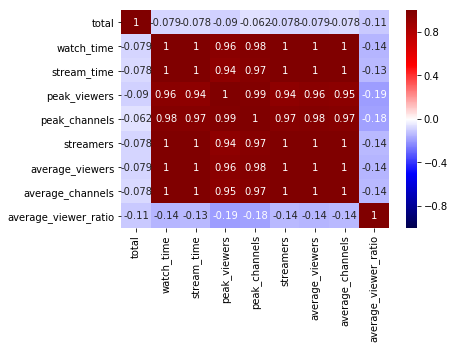

In [212]:
sns.heatmap(df_2018.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


In [214]:
# Define the model
lm1 = smf.ols('total ~ peak_viewers + peak_channels', data=df_2018)

# Fit the model
fit = lm1.fit()

# Print summary statistics of the model's performance
fit.summary()

/Users/nicksherwin/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  total   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                 -0.101
Method:                 Least Squares   F-statistic:                    0.2672
Date:                Thu, 18 Jul 2019   Prob (F-statistic):              0.769
Time:                        14:38:34   Log-Likelihood:                -239.59
No. Observations:                  17   AIC:                             485.2
Df Residuals:                      14   BIC:                             487.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      2.275e+05   1.36e+05      1.679      0.115   -6.31e+04    5.18e+05
peak_viewers     -2.7050      3.909     -0.692      0.500     -11.089       5.679
peak_channels    70.4066    108.960      0.646      0.529    -163.288     304.102
==============================================================================
Omnibus:                       39.719   Durbin-Watson:                   1.273
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              101.625
Skew:                           3.308   Prob(JB):                     8.56e-23
Kurtosis:                      12.985   Cond. No.                     2.54e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
df_2018.corr()

sns.heatmap(df_2018.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1);


# Define the model
lm1 = smf.ols('total ~ peak_viewers + peak_channels', data=df_2018)

# Fit the model
fit = lm1.fit()

# Print summary statistics of the model's performance
fit.summary()

